In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py, emcee
from copy import deepcopy as copy
import csv
import corner

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

# Isochrones

In [6]:
kwargs = {'thin':{'c':'tab:orange','alpha':1, 'linestyle':'-', 'label':'Thin disc', 'linewidth':2}, 
           'thick':{'c':'tab:green','alpha':1, 'linestyle':'-', 'label':'Thick disc', 'linewidth':2}, 
           'halo':{'c':'tab:purple','alpha':1, 'linestyle':'-', 'label':'Halo', 'linewidth':2}}

# Load isochrones from dat file

In [7]:
iso_properties = {'thin':{'age':6.9e9, 'feh':-0.3, 'file':'tau6900Myr_FeHm0p3'},
                 'thick':{'age':7.8e9, 'feh':-0.7, 'file':'tau7800Myr_FeHm0p7'},
                 'halo':{'age':12.5e9, 'feh':-1.5, 'file':'tau1250Myr_FeHm1p5'}}

In [8]:
directory = '/data/asfe2/Projects/mwtrace_data/isochrones'
files = ['tau6900Myr_FeHm0p3', 'tau7800Myr_FeHm0p7', 'tau1250Myr_FeHm1p5']

for cmpt in iso_properties:
    # read flash.dat to a list of lists
    datContent = [i.strip().split() for i in open(os.path.join(directory, iso_properties[cmpt]['file'])+'.dat').readlines()[12:-1]]
    datContent[0] = datContent[0][1:]

    # write it as a new CSV file
    with open(os.path.join(directory, iso_properties[cmpt]['file'])+'.csv', "w") as f:
        writer = csv.writer(f)
        writer.writerows(datContent)

In [9]:
file=iso_properties['thin']['file']
df = pd.read_csv(os.path.join(directory, file)+'.csv')#, usecols=['MH', 'logAge', 'Gmag'])
print(df.keys())

Index(['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe',
       'logg', 'label', 'McoreTP', 'C_O', 'period0', 'period1', 'period2',
       'period3', 'period4', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn',
       'Xo', 'Cexcess', 'Z', 'mbolmag', 'Gmag', 'G_BPmag', 'G_RPmag'],
      dtype='object')


In [10]:
columns = ['Gmag', 'G_BPmag', 'G_RPmag', 'Mini', 'Mass', 'logAge', 'MH']
relabel = ['gmag', 'g_bpmag', 'g_rpmag', 'mini', 'mass', 'age', 'feh']
relabel = dict(zip(columns, relabel))

for cmpt in iso_properties: 
    iso_properties[cmpt]['isochrone'] = pd.read_csv(os.path.join(directory, iso_properties[cmpt]['file'])+'.csv', 
                             usecols=columns).rename(columns=relabel).to_dict('list')
    
    for key in iso_properties[cmpt]['isochrone'].keys():
        iso_properties[cmpt]['isochrone'][key] = np.array(iso_properties[cmpt]['isochrone'][key])

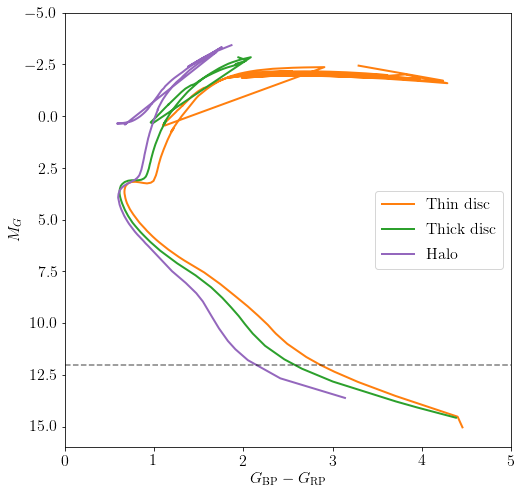

In [11]:
fig, axes = plt.subplots(1,1,figsize=(8,8), sharey=True)

for cmpt in iso_properties:
    pre_death = np.ones(len(iso_properties[cmpt]['isochrone']['gmag']), dtype=bool)
    pre_death[-1]=False
    plt.plot((iso_properties[cmpt]['isochrone']['g_bpmag']-iso_properties[cmpt]['isochrone']['g_rpmag'])[pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.ylim(16, -5); plt.xlim(0,5); plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$'); plt.ylabel(r'$M_G$');
plt.legend(loc='center right')

xlims = axes.get_xlim()
plt.plot([xlims[0], xlims[1]], [12,12], '--k', alpha=0.5)

plt.savefig('figs/isochrones_HRdiag.png', bbox_inches='tight')

# MIST isochrones

In [30]:
iso_properties = {'thin':{'age':6.9e9, 'feh':-0.3, 'file':'MIST_iso_6p9_m0p3'},
                 'thick':{'age':7.8e9, 'feh':-0.7, 'file':'MIST_iso_7p8_m0p7'},
                 'halo':{'age':12.5e9, 'feh':-1.5, 'file':'MIST_iso_12p9_m1p5'}}
for cmpt in iso_properties: print(np.log10(iso_properties[cmpt]['age']))

In [23]:
directory = '/data/asfe2/Projects/mwtrace_data/isochrones'
file = "MIST_iso_60f6e7f8d4cc1"

# read to a list of lists
datContent = [i.strip().split() for i in open(os.path.join(directory, file)+'.iso').readlines()[10:-1]]
datContent[0] = datContent[0][1:]

# write it as a new CSV file
with open(os.path.join(directory, file)+'.csv', "w") as f:
    writer = csv.writer(f)
    writer.writerows(datContent)
    
df = pd.read_csv(os.path.join(directory, file)+'.csv')

In [24]:
df

,EEP,log10_isochrone_age_yr,initial_mass,star_mass,star_mdot,he_core_mass,c_core_mass,log_L,log_LH,log_LHe,...,surface_he4,surface_c12,surface_o16,log_center_T,log_center_Rho,center_gamma,center_h1,center_he4,center_c12,phase
0,245,9.838849,0.173607,0.173605,-1.680445e-16,0.000000,0.000000,-2.448407,-2.448187,-67.327198,...,0.270286,0.002497,0.006109,6.782443,2.257178,0.236556,7.115246e-01,2.702861e-01,0.002497,0.0
1,246,9.838849,0.184729,0.184728,-1.868697e-16,0.000000,0.000000,-2.394359,-2.394075,-66.688036,...,0.270303,0.002497,0.006109,6.793514,2.222683,0.224561,7.113092e-01,2.703030e-01,0.002497,0.0
2,247,9.838849,0.195526,0.195524,-2.053902e-16,0.000000,0.000000,-2.342259,-2.341910,-66.082248,...,0.270324,0.002497,0.006109,6.804027,2.189355,0.213145,7.110958e-01,2.703241e-01,0.002497,0.0
3,248,9.838849,0.204765,0.204764,-2.217494e-16,0.000000,0.000000,-2.299039,-2.298631,-65.595776,...,0.270347,0.002497,0.006109,6.812503,2.161803,0.204037,7.109157e-01,2.703468e-01,0.002497,0.0
4,249,9.838849,0.210580,0.210578,-2.333732e-16,0.000000,0.000000,-2.276238,-2.275782,-65.374681,...,0.270367,0.002497,0.006109,6.816446,2.147891,0.200280,7.108271e-01,2.703673e-01,0.002497,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,1705,9.838849,1.156678,0.548123,-8.357802e-17,0.547844,0.458674,-1.142388,-1.959387,-99.000000,...,0.289049,0.001603,0.006090,7.608551,6.421568,17.007265,6.512021e-45,6.271155e-20,0.286057,6.0
1461,1706,9.838849,1.156768,0.548129,-7.752809e-17,0.547850,0.458983,-1.172368,-1.974078,-99.000000,...,0.289040,0.001601,0.006089,7.599506,6.422301,17.373954,4.812798e-45,6.188248e-20,0.286186,6.0
1462,1707,9.838849,1.156868,0.548136,-7.210039e-17,0.547857,0.459325,-1.202331,-1.988737,-99.000000,...,0.289029,0.001599,0.006089,7.590012,6.423030,17.766375,3.495607e-45,6.106204e-20,0.286329,6.0
1463,1708,9.838849,1.156980,0.548143,-6.739774e-17,0.547865,0.459708,-1.232275,-2.003406,-99.000000,...,0.289017,0.001596,0.006089,7.579968,6.423759,18.190942,2.492254e-45,6.024020e-20,0.286491,6.0


In [31]:
import csv

directory = '/data/asfe2/Projects/mwtrace_data/isochrones'
files = []

for cmpt in iso_properties:
    # read flash.dat to a list of lists
    datContent = [i.strip().split() for i in open(os.path.join(directory, iso_properties[cmpt]['file'])+'.iso.cmd').readlines()[12:-1]]
    datContent[0] = datContent[0][1:]

    # write it as a new CSV file
    with open(os.path.join(directory, iso_properties[cmpt]['file'])+'.csv', "w") as f:
        writer = csv.writer(f)
        writer.writerows(datContent)

In [33]:
file = iso_properties['thin']['file']
df = pd.read_csv(os.path.join(directory, file)+'.csv')#, usecols=['MH', 'logAge', 'Gmag'])
print(df.keys())

Index(['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass',
       'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U',
       'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J',
       '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp',
       'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev',
       'Gaia_RP_DR2Rev', 'Gaia_G_MAW', 'Gaia_BP_MAWb', 'Gaia_BP_MAWf',
       'Gaia_RP_MAW', 'TESS', 'Gaia_G_EDR3', 'Gaia_BP_EDR3', 'Gaia_RP_EDR3',
       'phase'],
      dtype='object')


In [48]:
columns = ['Gaia_G_EDR3', 'Gaia_BP_EDR3', 'Gaia_RP_EDR3', 'initial_mass', 'star_mass', 'log10_isochrone_age_yr', '[Fe/H]', 'EEP']
relabel = ['gmag', 'g_bpmag', 'g_rpmag', 'mini', 'mass', 'age', 'feh', 'EEP']
relabel = dict(zip(columns, relabel))

for cmpt in iso_properties: 
    iso_properties[cmpt]['isochrone'] = pd.read_csv(os.path.join(directory, iso_properties[cmpt]['file'])+'.csv', 
                             usecols=columns).rename(columns=relabel).to_dict('list')
    
    for key in iso_properties[cmpt]['isochrone'].keys():
        iso_properties[cmpt]['isochrone'][key] = np.array(iso_properties[cmpt]['isochrone'][key])

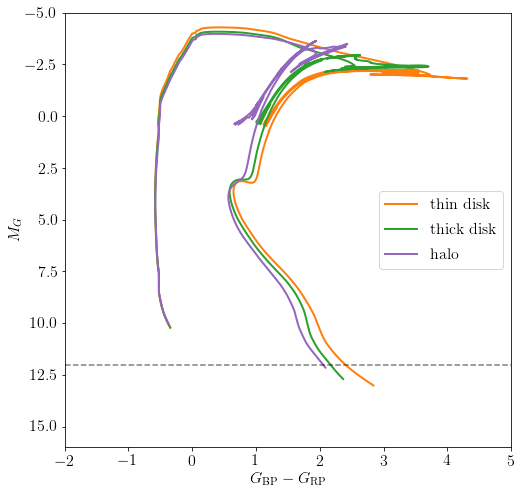

In [46]:
fig, axes = plt.subplots(1,1,figsize=(8,8), sharey=True)

for cmpt in iso_properties:
    pre_death = np.ones(len(iso_properties[cmpt]['isochrone']['gmag']), dtype=bool)
    #pre_death[-1]=False
    plt.plot((iso_properties[cmpt]['isochrone']['g_bpmag']-iso_properties[cmpt]['isochrone']['g_rpmag'])[pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.ylim(16, -5); plt.xlim(-2,5); plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$'); plt.ylabel(r'$M_G$');
plt.legend(loc='center right')

xlims = axes.get_xlim()
plt.plot([xlims[0], xlims[1]], [12,12], '--k', alpha=0.5)

# plt.savefig('figs/isochrones_HRdiag.png', bbox_inches='tight')

In [47]:
iso_properties['thin']

{'age': 6900000000.0,
 'feh': -0.3,
 'file': 'MIST_iso_6p9_m0p3',
 'isochrone': {'EEP': array([ 236,  237,  238, ..., 1707, 1708, 1709]),
  'age': array([9.83884909, 9.83884909, 9.83884909, ..., 9.83884909, 9.83884909,
         9.83884909]),
  'mini': array([0.10835082, 0.11204   , 0.11602867, ..., 1.08249663, 1.08260683,
         1.08272883]),
  'mass': array([0.10835018, 0.11203931, 0.11602794, ..., 0.54947472, 0.54948073,
         0.5494874 ]),
  'feh': array([-0.25736 , -0.257288, -0.257207, ..., -0.245963, -0.24596 ,
         -0.245957]),
  'gmag': array([13.007298, 12.896614, 12.776828, ..., 10.149353, 10.184256,
         10.218665]),
  'g_bpmag': array([14.629152, 14.47522 , 14.309795, ..., 10.02829 , 10.065185,
         10.101591]),
  'g_rpmag': array([11.787374, 11.688579, 11.581699, ..., 10.386034, 10.417046,
         10.447548])},
 'isointerp': <scipy.interpolate.interpolate.interp1d at 0x7f6fbcaa5318>,
 'massinterp': <scipy.interpolate.interpolate.interp1d at 0x7f6fbcaa5b88

## Load isochrones from WSDB

In [6]:
sys.path.append('/home/andy/Documents/software/')
import sqlutilpy, getdata

In [9]:
for observable in ['age', 'feh']:
    query = f"""select distinct {observable} from isochrones.gaia_1804"""
    %time uniage=sqlutilpy.get(query, asDict=True, **getdata.sql_args)

    for cmpt in iso_properties:
        iso_properties[cmpt]['iso'+observable] = uniage[observable][np.argmin(np.abs(uniage[observable] - iso_properties[cmpt][observable]))]

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.59 s
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 4.86 s


In [10]:
for cmpt in iso_properties:
    print(f"{cmpt}: age-{iso_properties[cmpt]['isoage']}, feh-{iso_properties[cmpt]['isofeh']}")

thin: age-6920000000.0, feh--0.3
thick: age-7760000000.0, feh--0.7
halo: age-12600000000.0, feh--1.5


In [11]:
for cmpt in iso_properties:
    query = f"""select gmag, g_bpmag, g_rpmag, mini, mass, age, feh, label from isochrones.gaia_1804
                    where age={iso_properties[cmpt]['isoage']}  and   feh={iso_properties[cmpt]['feh']}"""
    %time iso_properties[cmpt]['isochrone']=sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 854 ms
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 621 ms
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 547 ms


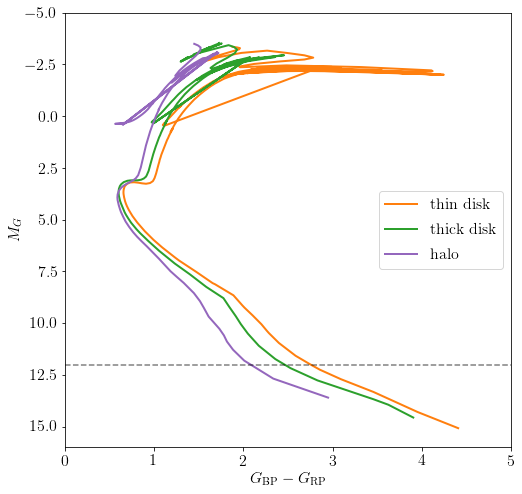

In [13]:
fig, axes = plt.subplots(1,1,figsize=(8,8), sharey=True)

for cmpt in iso_properties:
    pre_death = iso_properties[cmpt]['isochrone']['label']<9
    plt.plot((iso_properties[cmpt]['isochrone']['g_bpmag']-iso_properties[cmpt]['isochrone']['g_rpmag'])[pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.ylim(16, -5); plt.xlim(0,5); plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$'); plt.ylabel(r'$M_G$');
plt.legend(loc='center right')

xlims = axes.get_xlim()
plt.plot([xlims[0], xlims[1]], [12,12], '--k', alpha=0.5)

# plt.savefig('figs/isochrones_HRdiag.png', bbox_inches='tight')

## Interpolate

In [12]:
for cmpt in iso_properties:
    try: pre_death = iso_properties[cmpt]['isochrone']['label']<9
    except KeyError:
        pre_death = np.ones(len(iso_properties[cmpt]['isochrone']['gmag']), dtype=bool)
        pre_death[-1]=False
    iso_properties[cmpt]['isointerp'] = scipy.interpolate.interp1d(iso_properties[cmpt]['isochrone']['mini'][pre_death], 
                                                                   iso_properties[cmpt]['isochrone']['gmag'][pre_death],
                                                                      bounds_error=False, fill_value=np.nan)
    iso_properties[cmpt]['massinterp'] = scipy.interpolate.interp1d(iso_properties[cmpt]['isochrone']['mini'][pre_death], 
                                                                   iso_properties[cmpt]['isochrone']['mass'][pre_death],
                                                                      bounds_error=False, fill_value=np.nan)
    iso_properties[cmpt]['isointerp_inv'] = scipy.interpolate.interp1d(iso_properties[cmpt]['isochrone']['gmag'][pre_death], 
                                                                   iso_properties[cmpt]['isochrone']['mini'][pre_death],
                                                                      bounds_error=False, fill_value=np.nan)

# Draw initial-mass distribution

In [13]:
def imf_prob(x, ep1=1.3, ep2=2.3, m0=0.08, m1=0.5):
    
    mini = x[0]
    
    if mini<=0: return -1e30
    elif mini<m0: 
        return -1e30
        return -0.3*np.log(mini)
    elif mini<m1:
        return np.log(m0) - 1.3*np.log(mini)
    else:
        return np.log(m0) + np.log(m1) - 2.3*np.log(mini)
    
    return lnl

In [14]:
nwalkers=100; nstep=100000; ndim=1

p0 = np.random.rand(nwalkers,ndim)*3 + 0.08

sampler = emcee.EnsembleSampler(nwalkers, ndim, imf_prob)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0, iterations=nstep), total=nstep):
    pass

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100000 [00:00<?, ?it/s]

In [15]:
mini_sample = sampler.chain[:,int(nstep/4):,0].flatten()

KeyError: 'label'

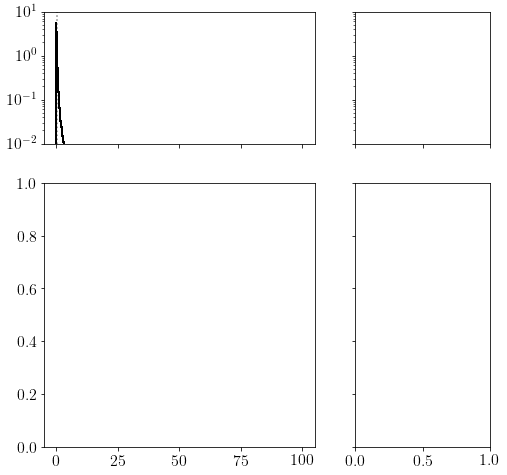

In [35]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey='row', sharex='col', 
                         gridspec_kw={'height_ratios':[1,2], 'width_ratios':[2,1]})

Mx = 12

plt.sca(axes[0,0])
plt.hist(mini_sample, bins=np.logspace(np.log10(0.09),2,100), histtype='step', density=True,
        color='k', linewidth=2);
plt.yscale('log'); plt.ylim(0.01,10)
ylims = axes[0,0].get_ylim()
plt.plot([0.5,0.5], [ylims[0], ylims[1]], ':k', alpha=0.5)

plt.sca(axes[1,0])
for cmpt in iso_properties:
    pre_death = iso_properties[cmpt]['isochrone']['label']<9
    plt.plot(iso_properties[cmpt]['isochrone']['mini'][pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.xlim(0.09,2); plt.ylim(16, -5); plt.xlabel(r'$\mathcal{M}_\mathrm{ini}$'); plt.ylabel(r'$M_G$');
plt.xscale('log')
plt.legend(loc='upper left')
xlims = axes[1,0].get_xlim()
plt.plot([xlims[0], xlims[1]], [Mx,Mx], '--k', alpha=0.5)
ylims = axes[1,0].get_ylim()
plt.plot([0.5,0.5], [ylims[0], ylims[1]], ':k', alpha=0.5)

plt.sca(axes[1,1])
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    g_sample[mini_sample<np.min(iso_properties[cmpt]['isochrone']['mini'])] = \
                    iso_properties[cmpt]['isochrone']['gmag'][0]
    g_hist = np.histogram(g_sample, bins=np.linspace(-5,16,100))
    x = g_hist[0]/(g_hist[1][1:]-g_hist[1][:-1]) / np.sum(g_hist[0])
    x = np.insert(np.repeat(x,2), (0,2*len(x)), (0,0))
    y = np.repeat(g_hist[1],2)
    plt.plot(x,y,**kwargs[cmpt])
plt.xscale('log'); plt.xlim(1e-5,1)

xlims = axes[1,1].get_xlim()
plt.plot([xlims[0], xlims[1]], [Mx,Mx], '--k', alpha=0.5)

plt.sca(axes[0,1]); plt.axis('off')

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.05)

# plt.savefig('figs/isochrones_Mini-MG_transform.png', bbox_inches='tight')

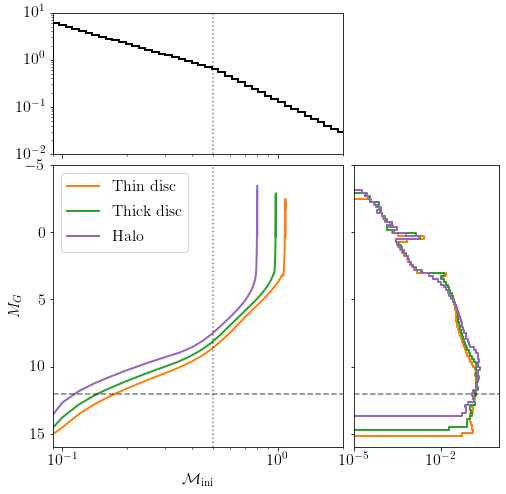

In [17]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey='row', sharex='col', 
                         gridspec_kw={'height_ratios':[1,2], 'width_ratios':[2,1]})

Mx = 12

plt.sca(axes[0,0])
plt.hist(mini_sample, bins=np.logspace(np.log10(0.09),2,100), histtype='step', density=True,
        color='k', linewidth=2);
plt.yscale('log'); plt.ylim(0.01,10)
ylims = axes[0,0].get_ylim()
plt.plot([0.5,0.5], [ylims[0], ylims[1]], ':k', alpha=0.5)

plt.sca(axes[1,0])
for cmpt in iso_properties:
    try: pre_death = iso_properties[cmpt]['isochrone']['label']<9
    except KeyError:
        pre_death = np.ones(len(iso_properties[cmpt]['isochrone']['gmag']), dtype=bool)
        pre_death[-1]=False
    plt.plot(iso_properties[cmpt]['isochrone']['mini'][pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.xlim(0.09,2); plt.ylim(16, -5); plt.xlabel(r'$\mathcal{M}_\mathrm{ini}$'); plt.ylabel(r'$M_G$');
plt.xscale('log')
plt.legend(loc='upper left')
xlims = axes[1,0].get_xlim()
plt.plot([xlims[0], xlims[1]], [Mx,Mx], '--k', alpha=0.5)
ylims = axes[1,0].get_ylim()
plt.plot([0.5,0.5], [ylims[0], ylims[1]], ':k', alpha=0.5)

plt.sca(axes[1,1])
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
#     g_sample[mini_sample<np.min(iso_properties[cmpt]['isochrone']['mini'])] = \
#                     iso_properties[cmpt]['isochrone']['gmag'][0]
    g_hist = np.histogram(g_sample, bins=np.linspace(-5,16,100))
    x = g_hist[0]/(g_hist[1][1:]-g_hist[1][:-1]) / np.sum(g_hist[0])
    x = np.insert(np.repeat(x,2), (0,2*len(x)), (0,0))
    y = np.repeat(g_hist[1],2)
    plt.plot(x,y,**kwargs[cmpt])
plt.xscale('log'); plt.xlim(1e-5,1)

xlims = axes[1,1].get_xlim()
plt.plot([xlims[0], xlims[1]], [Mx,Mx], '--k', alpha=0.5)

plt.sca(axes[0,1]); plt.axis('off')

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.05)

plt.savefig('figs/isochrones_Mini-MG_transform.png', bbox_inches='tight')

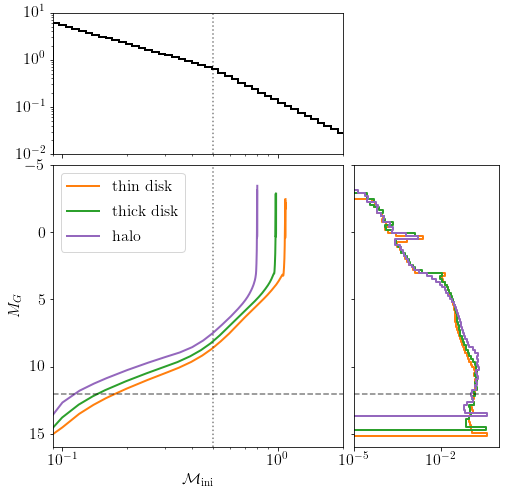

In [36]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey='row', sharex='col', 
                         gridspec_kw={'height_ratios':[1,2], 'width_ratios':[2,1]})

Mx = 12

plt.sca(axes[0,0])
plt.hist(mini_sample, bins=np.logspace(np.log10(0.09),2,100), histtype='step', density=True,
        color='k', linewidth=2);
plt.yscale('log'); plt.ylim(0.01,10)
ylims = axes[0,0].get_ylim()
plt.plot([0.5,0.5], [ylims[0], ylims[1]], ':k', alpha=0.5)

plt.sca(axes[1,0])
for cmpt in iso_properties:
    try: pre_death = iso_properties[cmpt]['isochrone']['label']<9
    except KeyError:
        pre_death = np.ones(len(iso_properties[cmpt]['isochrone']['gmag']), dtype=bool)
        pre_death[-1]=False
    plt.plot(iso_properties[cmpt]['isochrone']['mini'][pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.xlim(0.09,2); plt.ylim(16, -5); plt.xlabel(r'$\mathcal{M}_\mathrm{ini}$'); plt.ylabel(r'$M_G$');
plt.xscale('log')
plt.legend(loc='upper left')
xlims = axes[1,0].get_xlim()
plt.plot([xlims[0], xlims[1]], [Mx,Mx], '--k', alpha=0.5)
ylims = axes[1,0].get_ylim()
plt.plot([0.5,0.5], [ylims[0], ylims[1]], ':k', alpha=0.5)

plt.sca(axes[1,1])
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    g_sample[mini_sample<np.min(iso_properties[cmpt]['isochrone']['mini'])] = \
                    iso_properties[cmpt]['isochrone']['gmag'][0]
    g_hist = np.histogram(g_sample, bins=np.linspace(-5,16,100))
    x = g_hist[0]/(g_hist[1][1:]-g_hist[1][:-1]) / np.sum(g_hist[0])
    x = np.insert(np.repeat(x,2), (0,2*len(x)), (0,0))
    y = np.repeat(g_hist[1],2)
    plt.plot(x,y,**kwargs[cmpt])
plt.xscale('log'); plt.xlim(1e-5,1)

xlims = axes[1,1].get_xlim()
plt.plot([xlims[0], xlims[1]], [Mx,Mx], '--k', alpha=0.5)

plt.sca(axes[0,1]); plt.axis('off')

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.05)

# plt.savefig('figs/isochrones_Mini-MG_transform.png', bbox_inches='tight')

In [104]:
mini_sample

array([4.40059823e-125, 3.24761356e-125, 5.96734265e-125, ...,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

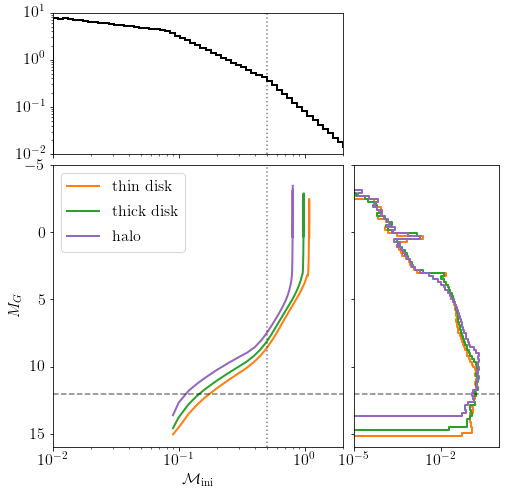

In [130]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey='row', sharex='col', 
                         gridspec_kw={'height_ratios':[1,2], 'width_ratios':[2,1]})

Mx = 12

plt.sca(axes[0,0])
plt.hist(mini_sample, bins=np.logspace(np.log10(0.01),2,100), histtype='step', density=True,
        color='k', linewidth=2);
plt.yscale('log'); plt.ylim(0.01,10)
ylims = axes[0,0].get_ylim()
plt.plot([0.5,0.5], [ylims[0], ylims[1]], ':k', alpha=0.5)

plt.sca(axes[1,0])
for cmpt in iso_properties:
    try: pre_death = iso_properties[cmpt]['isochrone']['label']<9
    except KeyError:
        pre_death = np.ones(len(iso_properties[cmpt]['isochrone']['gmag']), dtype=bool)
        pre_death[-1]=False
    plt.plot(iso_properties[cmpt]['isochrone']['mini'][pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.xlim(0.01,2); plt.ylim(16, -5); plt.xlabel(r'$\mathcal{M}_\mathrm{ini}$'); plt.ylabel(r'$M_G$');
plt.xscale('log')
plt.legend(loc='upper left')
xlims = axes[1,0].get_xlim()
plt.plot([xlims[0], xlims[1]], [Mx,Mx], '--k', alpha=0.5)
ylims = axes[1,0].get_ylim()
plt.plot([0.5,0.5], [ylims[0], ylims[1]], ':k', alpha=0.5)

plt.sca(axes[1,1])
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
#     g_sample[mini_sample<np.min(iso_properties[cmpt]['isochrone']['mini'])] = \
#                     iso_properties[cmpt]['isochrone']['gmag'][0]
    g_hist = np.histogram(g_sample, bins=np.linspace(-5,16,100))
    x = g_hist[0]/(g_hist[1][1:]-g_hist[1][:-1]) / np.sum(g_hist[0])
    x = np.insert(np.repeat(x,2), (0,2*len(x)), (0,0))
    y = np.repeat(g_hist[1],2)
    plt.plot(x,y,**kwargs[cmpt])
plt.xscale('log'); plt.xlim(1e-5,1)

xlims = axes[1,1].get_xlim()
plt.plot([xlims[0], xlims[1]], [Mx,Mx], '--k', alpha=0.5)

plt.sca(axes[0,1]); plt.axis('off')

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.05)

# plt.savefig('figs/isochrones_Mini-MG_transform.png', bbox_inches='tight')

In [128]:
iso_properties['halo']['isointerp'](0.05)

array(nan)

In [18]:
g_sample = iso_properties['thin']['isointerp'](mini_sample)

In [19]:
iso_properties['thin']['isointerp_inv'](12), \
iso_properties['thick']['isointerp_inv'](12)

(array(0.17671684), array(0.14687629))

In [20]:
g_sample[mini_sample<0.05]

array([], dtype=float64)

### Component mean mass

In [21]:
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    mass_sample = iso_properties[cmpt]['massinterp'](mini_sample)
    iso_properties[cmpt]['mean_mass']=np.mean(mass_sample[g_sample<12])
    print(f"{cmpt} mean mass: {iso_properties[cmpt]['mean_mass']:.4f}Ms")

thin mean mass: 0.4184Ms
thick mean mass: 0.3711Ms
halo mean mass: 0.3091Ms


In [22]:
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    mass_sample = iso_properties[cmpt]['massinterp'](mini_sample)
    iso_properties[cmpt]['mean_frac']=np.nansum(mass_sample[g_sample<12])/np.nansum(mass_sample)
    print(f"{cmpt} mass fraction: {100*iso_properties[cmpt]['mean_frac']:.2f}%")

thin mass fraction: 84.68%
thick mass fraction: 89.08%
halo mass fraction: 94.39%


### Initial Mass
- Bovy comparison

In [19]:
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    print(f"{cmpt} mean initial mass: {np.mean(mini_sample[g_sample<12]):.4f}Ms")

thin mean initial mass: 0.4176Ms
thick mean initial mass: 0.3705Ms
halo mean initial mass: 0.3084Ms


In [88]:
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    print(f"{cmpt} mass fraction: {100*np.sum(mini_sample[g_sample<12])/np.sum(mini_sample):.2f}%")

thin mass fraction: 35.13%
thick mass fraction: 35.22%
halo mass fraction: 33.39%


In [67]:
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    mass_sample = iso_properties[cmpt]['massinterp'](mini_sample)
    iso_properties[cmpt]['mean_mass']=np.mean(mass_sample[g_sample<12])
    print(f"{cmpt} mean mass: {iso_properties[cmpt]['mean_mass']:.4f}Ms")

thin mean mass: 0.3783Ms
thick mean mass: 0.3457Ms
halo mean mass: 0.3031Ms


In [71]:
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    print(f"{cmpt} mean mass: {np.mean(mini_sample[g_sample<12]):.4f}Ms")

thin mean mass: 0.3785Ms
thick mean mass: 0.3459Ms
halo mean mass: 0.3032Ms


In [76]:
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    print(f"{cmpt} mean mass: {( np.sum(mini_sample[g_sample<12])/np.sum(mini_sample) ):.4f}")

thin mean mass: 0.3750
thick mean mass: 0.3665
halo mean mass: 0.3341


### Component mean weight
-  Mass fractions from Juric+ 2008

In [23]:
iso_properties['thin']['rho'] = 1.
iso_properties['thick']['rho'] = 0.12
iso_properties['halo']['rho'] = 0.005

for cmpt in iso_properties:
    iso_properties[cmpt]['w_0']=iso_properties[cmpt]['rho']*iso_properties['thin']['mean_mass']/iso_properties[cmpt]['mean_mass']
    print(f"{cmpt} w_0/w_thin: {iso_properties[cmpt]['w_0']:.4f}")

thin w_0/w_thin: 1.0000
thick w_0/w_thin: 0.1353
halo w_0/w_thin: 0.0068


In [24]:
total = np.sum([iso_properties[cmpt]['w_0'] for cmpt in iso_properties])
for cmpt in iso_properties:
    print(f"{cmpt} w0: {iso_properties[cmpt]['w_0']/total:.4f}")

thin w0: 0.8756
thick w0: 0.1185
halo w0: 0.0059


In [25]:
iso_properties['thin']['hz'] = 0.3
iso_properties['thick']['hz'] = 0.9
iso_properties['halo']['hz'] = 3.74
R0=8.27

In [26]:
# Correcting for component normalisation
iso_properties['thin']['w'] = iso_properties['thin']['w_0'] * iso_properties['thin']['hz']**3
iso_properties['thick']['w'] = iso_properties['thick']['w_0'] * iso_properties['thick']['hz']**3
halo_norm = 8/(np.sqrt(np.pi)*R0**3) * scipy.special.gamma(iso_properties['halo']['hz']/2)/scipy.special.gamma((iso_properties['halo']['hz']-3)/2)
iso_properties['halo']['w'] = iso_properties['halo']['w_0'] / halo_norm


total = np.sum([iso_properties[cmpt]['w'] for cmpt in iso_properties])
for cmpt in iso_properties:
    print(f"{cmpt} w: {iso_properties[cmpt]['w']/total:.5f}")

thin w: 0.01191
thick w: 0.04350
halo w: 0.94460


### Magnitude distributions

In [27]:
Mx=12
fid_pars = {'Mmax':Mx,  'lat_min':60, 'R0':8.27,
            'functions':{}, 'functions_inv':{}, 'jacobians':{}, 'w':True,
            'components':['disk','disk','halo'], 'ncomponents':3}

M_arr = np.linspace(-5,Mx,100)

shared = {'w':1, 'alpha1':-0.1, 'alpha2':-.2, 'Mms2':8, 'Mms':9, 'Mms1':10}
fid_pars['fixed_pars']={'Mx':Mx, 
        0:dict({'alpha3':-.9, 'Mto':3.1}, **shared),
        1:dict({'alpha3':-.7, 'Mto':3.1}, **shared),
        2:dict({'alpha3':-.7, 'Mto':3.1}, **shared),}

for i, cmpt in enumerate(iso_properties):
    fid_pars['fixed_pars'][i]['fD'] = 1- \
    np.sum(iso_properties[cmpt]['isointerp'](mini_sample) < fid_pars['fixed_pars'][i]['Mto'])/\
    np.sum(iso_properties[cmpt]['isointerp'](mini_sample) < fid_pars['Mmax'])
    fid_pars['fixed_pars'][i]['fD'] = np.round(fid_pars['fixed_pars'][i]['fD'], 4)
    
    transitions = np.hstack((np.array([fid_pars['fixed_pars'][i][par] for par in ['Mms', 'Mms1', 'Mms2']]),
                np.array([fid_pars['fixed_pars'][i]['Mto'] for i in range(3)])))
    M_arr = np.sort(np.hstack((M_arr, transitions-1e-10, transitions+1e-10)))

fid_pars['free_pars']={0:[],1:[],2:[],'shd':[]}

components = dh_msto.M_model(M_arr, np.array([]), fid_pars=fid_pars, model='all')

In [28]:
fid_pars['fixed_pars']

{'Mx': 12,
 0: {'alpha3': -0.9,
  'Mto': 3.1,
  'w': 1,
  'alpha1': -0.1,
  'alpha2': -0.2,
  'Mms2': 8,
  'Mms': 9,
  'Mms1': 10,
  'fD': 0.9954},
 1: {'alpha3': -0.7,
  'Mto': 3.1,
  'w': 1,
  'alpha1': -0.1,
  'alpha2': -0.2,
  'Mms2': 8,
  'Mms': 9,
  'Mms1': 10,
  'fD': 0.9945},
 2: {'alpha3': -0.7,
  'Mto': 3.1,
  'w': 1,
  'alpha1': -0.1,
  'alpha2': -0.2,
  'Mms2': 8,
  'Mms': 9,
  'Mms1': 10,
  'fD': 0.9965}}

Text(0.5, 0, '$M_G$')

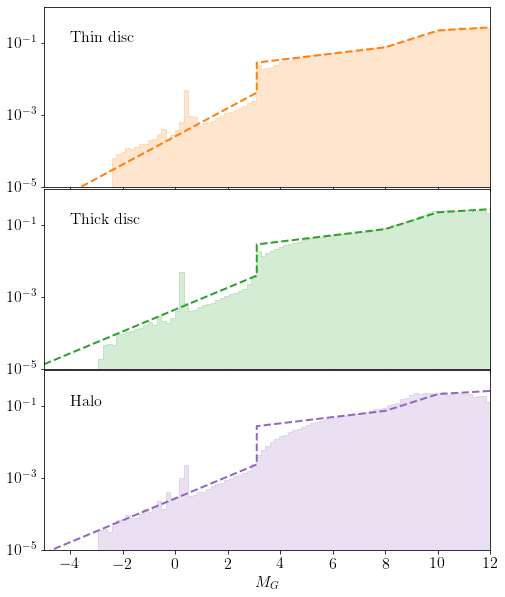

In [29]:
fig, axes = plt.subplots(3,1,figsize=(8,10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.01)

for i, cmpt in enumerate(iso_properties):
    plt.sca(axes[i])
    
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    g_hist = np.histogram(g_sample, bins=np.linspace(-5,Mx,100))
    y = g_hist[0]/(g_hist[1][1:]-g_hist[1][:-1]) / np.sum(g_hist[0])
    y = np.insert(np.repeat(y,2), (0,2*len(y)), (0,0))
    x = np.repeat(g_hist[1],2)
    plt.fill_between(x,np.zeros(len(y)),y,color=kwargs[cmpt]['c'], alpha=0.2)
    
    plt.plot(M_arr, components[:,i],c=kwargs[cmpt]['c'],linestyle='--',linewidth=2)
    
    plt.text(-4,0.1,kwargs[cmpt]['label'])
plt.yscale('log'); plt.ylim(1e-5,1); plt.xlim(-5,Mx)

plt.xlabel(r'$M_G$')

#plt.savefig('figs/isochrones_MG_model.png', bbox_inches='tight')

### Dwarf fraction

In [30]:
for i, cmpt in enumerate(iso_properties):
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    iso_properties[cmpt]['fD']=1-np.sum(g_sample<fid_pars['fixed_pars'][i]['Mto'])/np.sum(g_sample<12)
    print(f"{cmpt} fD: {iso_properties[cmpt]['fD']:.4f}")

thin fD: 0.9954
thick fD: 0.9945
halo fD: 0.9965


## Fixed parameters

In [31]:
Mx=12
fid_pars = {'Mmax':Mx,  'lat_min':60, 'R0':8.27,
            'functions':{}, 'functions_inv':{}, 'jacobians':{}, 'w':True,
            'components':['disk','disk','halo'], 'ncomponents':3}

M_arr = np.linspace(-5,Mx,100)

shared = {'Mms2':8, 'Mms':9, 'Mms1':10, 'Mto':3.1}

### Giant power law slope

In [32]:
def M_model(params, M, fD=0., Mto=4, Mms=8, Mms1=9, Mms2=7):
    
    alpha3 = params[0]
    if alpha3>0.: return -1e20

    # Latent variables
    n3 = -(4 + alpha3*5/np.log(10))

    pop1 = M>Mms1
    popg = M>Mms2
    pop2 = M>Mto
    
    log_AG = np.log(-alpha3) + np.log(1-fD)

    log_m = log_AG  + alpha3*(Mto-M)
    
    return np.sum(log_m)

In [33]:
nwalkers=10; ndim=1; nstep=500
chains = np.zeros((3,nwalkers,nstep,ndim))

for i, cmpt in enumerate(iso_properties):
    
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    lnlike = lambda x: M_model(x, g_sample[g_sample<shared['Mto']],
                                       Mto=shared['Mto'],
                                       Mms=shared['Mms'],
                                       Mms1=shared['Mms1'],
                                       Mms2=shared['Mms2'])
    
    p0_walkers = np.random.normal(-1,0.1,size=(nwalkers, ndim))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike)
    for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
        pass
    
    chains[i]=sampler.chain

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

thin alpha3: -0.6059
thick alpha3: -0.7699
halo alpha3: -0.6498


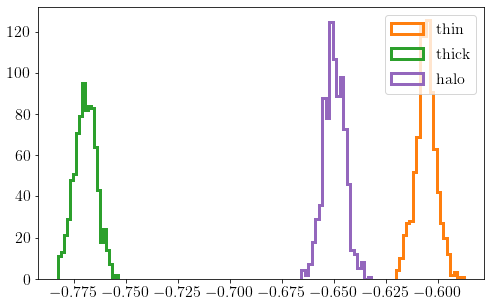

In [34]:
fig = plt.figure(figsize=(8,5))
for i, cmpt in enumerate(iso_properties):
    flatchain = chains[i,:,int(nstep/2)::3,0].flatten()
    plt.hist(flatchain, bins=20, color=kwargs[cmpt]['c'], histtype='step', linewidth=3, label=cmpt)
    iso_properties[cmpt]['alpha3']=np.mean(flatchain)
    print(f"{cmpt} alpha3: {iso_properties[cmpt]['alpha3']:.4f}")
plt.legend()

thin alpha3: -0.6000
thick alpha3: -0.7717
halo alpha3: -0.6372


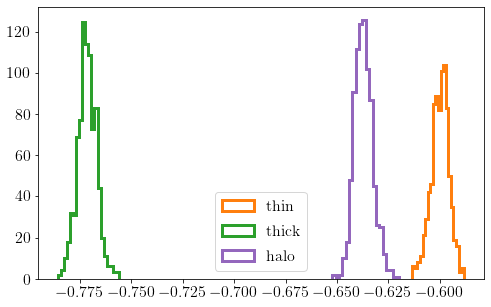

### Main sequence power law slope

In [30]:
shared

{'Mms2': 8, 'Mms': 9, 'Mms1': 10, 'Mto': 3.1}

In [35]:
def M_model(params, M, fD=1., Mto=4, Mms=8, Mms1=9, Mms2=7):
    
    alpha1, alpha2 = params
    if (alpha1>0.)|(alpha2>0.): return -1e20
    
    ep1=1.3; ep2=2.3;
    a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);

    alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
    Ag = 1/a1 * np.exp((alpha1-alphag)*(Mms-Mms1))

    # Latent variables
    n1 = -(4 + alpha1*5/np.log(10))
    ng = -(4 + alphag*5/np.log(10))
    n2 = -(4 + alpha2*5/np.log(10))

    pop1 = M>Mms1
    popg = M>Mms2

    log_Ams = np.log( fD*a1*a2 ) - \
              scipy.special.logsumexp(np.array([alpha1*(Mms-Mms1), alpha1*(Mms-Mx),
                                                alpha1*(Mms-Mms1)+alphag*(Mms1-Mms2), alpha1*(Mms-Mms1),
                                                alpha2*(Mms-Mto), alpha2*(Mms-Mms2)]),
                                    b=np.array([a2/alpha1, -a2/alpha1,
                                                a2/alphag, -a2/alphag,
                                                a1/alpha2, -a1/alpha2]))

    log_m = log_Ams  + np.where(pop1, - np.log(a1) + alpha1*(Mms-M),
                       np.where(popg, + np.log(Ag) + alphag*(Mms-M),
                                      - np.log(a2) + alpha2*(Mms-M)))
    
    return np.sum(log_m)

In [62]:
iso_properties[cmpt]['w']/w_total

NameError: name 'w_total' is not defined

In [36]:
g_sample = np.array([])
size = 1e5
w_total = np.sum([iso_properties[cmpt]['w_0'] for cmpt in iso_properties])
for i, cmpt in enumerate(iso_properties):
    cmpt_size = int(size * iso_properties[cmpt]['w_0']/w_total)
    print(cmpt_size)
    cmpt_sample = np.random.choice(np.arange(len(mini_sample)), cmpt_size, replace=False)
    g_sample = np.hstack((g_sample, iso_properties[cmpt]['isointerp'](mini_sample)[cmpt_sample]))

87562
11845
592


In [37]:
nwalkers=10; ndim=2; nstep=500

lnlike = lambda x: M_model(x, g_sample[(g_sample>shared['Mto'])&(g_sample<Mx)],
                                   Mto=shared['Mto'],
                                   Mms=shared['Mms'], Mms1=shared['Mms1'], Mms2=shared['Mms2'])

p0_walkers = np.random.normal(-1,0.1,size=(nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
    pass

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/500 [00:00<?, ?it/s]

alpha1: -0.1110, alpha2: -0.2515


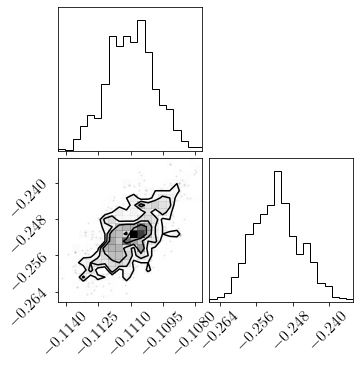

In [38]:
flatchain = sampler.chain[:,int(nstep/2)::3].reshape(-1,ndim)
corner.corner(flatchain);

shared['alpha1'], shared['alpha2'] = np.mean(flatchain, axis=0)
print(f"alpha1: {shared['alpha1']:.4f}, alpha2: {shared['alpha2']:.4f}")

# Plot with fitted parameters

In [39]:
fid_pars['fixed_pars']={'Mx':Mx}
for i, cmpt in enumerate(iso_properties):
    fid_pars['fixed_pars'][i] = dict({'alpha3':iso_properties[cmpt]['alpha3'], 
                                      'fD':iso_properties[cmpt]['fD'],
                                      'w':iso_properties[cmpt]['w']}, **shared)

In [40]:
for i, cmpt in enumerate(iso_properties):
    fid_pars['fixed_pars'][i]['fD'] = 1- \
    np.sum(iso_properties[cmpt]['isointerp'](mini_sample) < fid_pars['fixed_pars'][i]['Mto'])/\
    np.sum(iso_properties[cmpt]['isointerp'](mini_sample) < fid_pars['Mmax'])
    fid_pars['fixed_pars'][i]['fD'] = np.round(fid_pars['fixed_pars'][i]['fD'], 4)
    
    transitions = np.hstack((np.array([fid_pars['fixed_pars'][i][par] for par in ['Mms', 'Mms1', 'Mms2']]),
                np.array([fid_pars['fixed_pars'][i]['Mto'] for i in range(3)])))
    M_arr = np.sort(np.hstack((M_arr, transitions-1e-10, transitions+1e-10)))

fid_pars['free_pars']={0:[],1:[],2:[],'shd':[]}

components = dh_msto.M_model(M_arr, np.array([]), fid_pars=fid_pars, model='all')

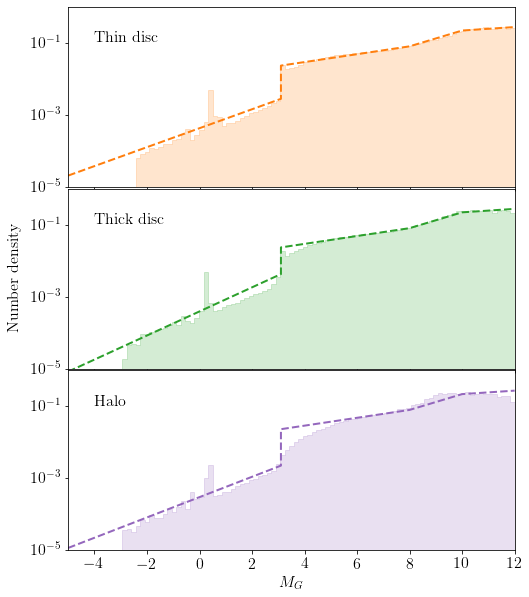

In [42]:
fig, axes = plt.subplots(3,1,figsize=(8,10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.01)

for i, cmpt in enumerate(iso_properties):
    plt.sca(axes[i])
    
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    g_hist = np.histogram(g_sample, bins=np.linspace(-5,Mx,100))
    y = g_hist[0]/(g_hist[1][1:]-g_hist[1][:-1]) / np.sum(g_hist[0])
    y = np.insert(np.repeat(y,2), (0,2*len(y)), (0,0))
    x = np.repeat(g_hist[1],2)
    plt.fill_between(x,np.zeros(len(y)),y,color=kwargs[cmpt]['c'], alpha=0.2)
    
    plt.plot(M_arr, components[:,i]/fid_pars['fixed_pars'][i]['w'], 
             c=kwargs[cmpt]['c'],linestyle='--',linewidth=2)
    
    if i==1: 
        plt.ylabel('Number density', labelpad=10)
    
    plt.text(-4,0.1,kwargs[cmpt]['label'])
plt.yscale('log'); plt.ylim(1e-5,1); plt.xlim(-5,Mx)

plt.xlabel(r'$M_G$')

plt.savefig('figs/isochrones_MG_model_fit.png', bbox_inches='tight')

In [133]:
fid_pars['fixed_pars']

{'Mx': 12,
 0: {'alpha3': -0.5999917859432182,
  'fD': 0.9955,
  'w': 0.026999999999999996,
  'Mms2': 8,
  'Mms': 9,
  'Mms1': 10,
  'Mto': 3.1,
  'alpha1': -0.11141926403561311,
  'alpha2': -0.24538518783624008},
 1: {'alpha3': -0.7717384196922594,
  'fD': 0.9946,
  'w': 0.09862482035451522,
  'Mms2': 8,
  'Mms': 9,
  'Mms1': 10,
  'Mto': 3.1,
  'alpha1': -0.11141926403561311,
  'alpha2': -0.24538518783624008},
 2: {'alpha3': -0.6372314078445765,
  'fD': 0.9965,
  'w': 2.140933456183005,
  'Mms2': 8,
  'Mms': 9,
  'Mms1': 10,
  'Mto': 3.1,
  'alpha1': -0.11141926403561311,
  'alpha2': -0.24538518783624008}}

In [324]:
fid_pars['fixed_pars']

{'Mx': 12,
 0: {'alpha3': -0.6021901421628681,
  'fD': 0.0044522248674430795,
  'w': 1.0,
  'Mms2': 8,
  'Mms': 9,
  'Mms1': 10,
  'Mto': 3.1,
  'alpha1': -0.11579438897983448,
  'alpha2': -0.2697959854426695},
 1: {'alpha3': -0.7334036765652955,
  'fD': 0.0052265327993776135,
  'w': 0.13416105719126437,
  'Mms2': 8,
  'Mms': 9,
  'Mms1': 10,
  'Mto': 3.1,
  'alpha1': -0.11579438897983448,
  'alpha2': -0.2697959854426695},
 2: {'alpha3': -0.6286748783859065,
  'fD': 0.0034288680937870912,
  'w': 0.006689311156602675,
  'Mms2': 8,
  'Mms': 9,
  'Mms1': 10,
  'Mto': 3.1,
  'alpha1': -0.11579438897983448,
  'alpha2': -0.2697959854426695}}

# Model Mass Fraction

In [36]:
def initial_mass_function(m, model='Kroupa'):
    if np.isscalar(m): m = np.array([m])
    imf = np.zeros(len(m))
    if model=='Kroupa':
        
        m0=0.08; m1=0.5
        e0=0.3; e1=1.3; e2=2.3
        
        imf[m<=m0] = m[m<=m0]**-e0
        imf[(m>m0)&(m<=m1)] = m0*m[(m>m0)&(m<=m1)]**-e1
        imf[(m>m1)] = m0*m1*m[(m>m1)]**-e2
        
        I0 = 1/(1-e0) * (m0**(1-e0))
        I1 = m0/(1-e1) * (m1**(1-e1)-m0**(1-e1))
        I2 = m0*m1/(1-e2) * (-m1**(1-e2))
        I = I0 + I1 + I2
        
        return imf/I
    
    if model=='Chabrier':
        
        m0=1e-50; m1=1.0
        A0=0.158; mc=0.079; s=0.69
        A0=0.086; mc=0.22; s=0.57
        alpha=2.3
        
        #mc=0.6; s=0.1
        
        I0 = 0.5 * (scipy.special.erf( (np.log10(m1) - np.log10(mc))/(np.sqrt(2)*s) ) \
                  - scipy.special.erf( (np.log10(m0) - np.log10(mc))/(np.sqrt(2)*s) ))
        A1 = 1/(np.sqrt(2*np.pi)*s) * np.exp(-(np.log10(m1)-np.log10(mc))**2/(2*s**2)) * m1**(alpha-1)/np.log(10)
        I1 = A1/(2-alpha) * (-m1**(2-alpha))
        I = I0+I1
        
        imf[m<=m1] = 1/(np.sqrt(2*np.pi)*s) * np.exp(-(np.log10(m[m<=m1] )-np.log10(mc))**2/(2*s**2)) \
                      /(m[m<=m1]*np.log(10))
        imf[m>m1] = A1 * m[m>m1]**-alpha
            
        return imf/I

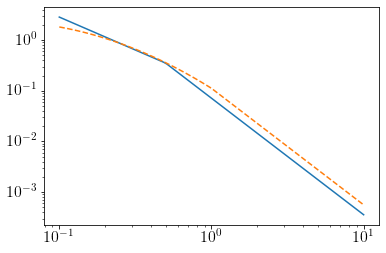

In [37]:
m = np.logspace(-1,1,100)
plt.plot(m, initial_mass_function(m,model='Kroupa'))
plt.plot(m, initial_mass_function(m,model='Chabrier'), linestyle='--')
plt.yscale('log'); plt.xscale('log')

In [116]:
from scipy.integrate import quad
import warnings
warnings.filterwarnings('ignore')

In [128]:
for cmpt in iso_properties:
    
    m_min = iso_properties[cmpt]['isointerp_inv'](12)
    m_argmax = np.argmax(iso_properties[cmpt]['isochrone']['mini'][:-1])
    m_max = iso_properties[cmpt]['isochrone']['mini'][m_argmax]
    
    def number(x): 
        n = initial_mass_function(x, model='Kroupa')
        if (x>0.1)&(x<m_max): n *= iso_properties[cmpt]['massinterp'](x)/x
        return n
    mass = lambda x: x*number(x)
    
    upper_limit = 2000
    
    I = quad(number, 0, m_max)[0]
    Ilow = quad(number, 0, m_min)[0]
    M = quad(mass, 0, m_max)[0]
    Mlow = quad(mass, 0, m_min)[0]
    
    X = (I)/(I-Ilow)
    Mmean = (M)/(I)
    print(f"{cmpt.ljust(5)}: {m_min:.3f}, {m_max:.3f}")
    print(f"{cmpt.ljust(5)}: X:{X:.3f}, <M>:{Mmean:.3f}, multiplier:{X*Mmean:.3f}")

thin : 0.177, 1.083
thin : X:3.167, <M>:0.174, multiplier:0.552
thick: 0.147, 0.980
thick: X:2.785, <M>:0.168, multiplier:0.468
halo : 0.115, 0.801
halo : X:2.398, <M>:0.155, multiplier:0.372


In [321]:
10**iso_properties['thin']['isochrone']['age']/1e9

array([6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001445,
       6.90001445, 6.90001445, 6.90001445, 6.90001445, 6.90001

In [142]:
print('Replicating Bovy')
for cmpt in iso_properties:
    
    m_min = iso_properties[cmpt]['isointerp_inv'](12)
    m_argmax = np.argmax(iso_properties[cmpt]['isochrone']['mini'][:-1])
    m_max = iso_properties[cmpt]['isochrone']['mini'][m_argmax]
    
    def number(x): 
        n = initial_mass_function(x, model='Kroupa')
        if (x>0.1)&(x<m_max): n *= iso_properties[cmpt]['massinterp'](x)/x
        elif (x>m_max): n *= iso_properties[cmpt]['massinterp'](m_max)/m_max
        return n
    mass = lambda x: x*number(x)
    
    upper_limit = 2000
    
    I = quad(number, 0, upper_limit)[0]
    Ihigh = quad(number, m_max, upper_limit)[0]
    Ilow = quad(number, 0, m_min)[0]
    M = quad(mass, 0, upper_limit)[0]
    Mhigh = quad(mass, m_max, upper_limit)[0]
    Mlow = quad(mass, 0, m_min)[0]
    
    X = (I)/(I-Ilow-Ihigh)
    Mmean = (M)/(I)
    print(f"{cmpt.ljust(5)}: {m_min:.3f}, {m_max:.3f}")
    print(f"{cmpt.ljust(5)}: X:{X:.3f}, <M>:{Mmean:.3f}, multiplier:{X*Mmean:.3f}")

Replicating Bovy
thin : 0.177, 1.083
thin : X:3.255, <M>:0.290, multiplier:0.943
thick: 0.147, 0.980
thick: X:2.892, <M>:0.301, multiplier:0.870
halo : 0.115, 0.801
halo : X:2.568, <M>:0.353, multiplier:0.906


### Extended thin disk star formation

In [208]:
age_bins = np.array([0.,0.15,0.3,0.6,1.2,2,3,4,5,6,7,8])*1e9
np.log10((age_bins[1:]+age_bins[:-1])/2)

array([7.87506126, 8.35218252, 8.65321251, 8.95424251, 9.20411998,
       9.39794001, 9.54406804, 9.65321251, 9.74036269, 9.81291336,
       9.87506126])

In [288]:
directory = '/data/asfe2/Projects/mwtrace_data/isochrones'
file = 'thin_disk/thin_disk_isochrones'

i_iso=0
datContent = []
for iline, line in enumerate(open(os.path.join(directory, file)+'.dat').readlines()[12:-1]):
        
    if (line[0]=='#'):
        if iline>0:
            # write it as a new CSV file
            with open(os.path.join(directory, file)+f'_{i_iso}.csv', "w") as f:
                writer = csv.writer(f)
                writer.writerows(datContent)
            i_iso+=1
        
        datContent = [line[1:].strip().split(),]
        
    else: datContent += [line.strip().split(),]
        
# write it as a new CSV file
with open(os.path.join(directory, file)+f'_{i_iso}.csv', "w") as f:
    writer = csv.writer(f)
    writer.writerows(datContent)

In [289]:
columns = ['Gmag', 'G_BPmag', 'G_RPmag', 'Mini', 'Mass', 'logAge', 'MH']
relabel = ['gmag', 'g_bpmag', 'g_rpmag', 'mini', 'mass', 'age', 'feh']
relabel = dict(zip(columns, relabel))

isochrones={}
for i_iso in range(9):
    isochrones[i_iso] = {}
    isochrones[i_iso]['isochrone'] = pd.read_csv(os.path.join(directory, file)+f'_{i_iso}.csv', 
                                 usecols=columns).rename(columns=relabel).to_dict('list')

    for key in isochrones[i_iso]['isochrone'].keys():
        isochrones[i_iso]['isochrone'][key] = np.array(isochrones[i_iso]['isochrone'][key]).astype(float)

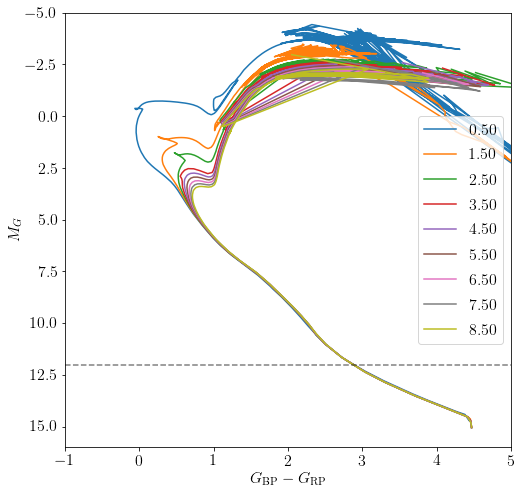

In [292]:
fig, axes = plt.subplots(1,1,figsize=(8,8), sharey=True)

for i_iso in isochrones:
    plt.plot((isochrones[i_iso]['isochrone']['g_bpmag']-isochrones[i_iso]['isochrone']['g_rpmag'])[:-1], 
             isochrones[i_iso]['isochrone']['gmag'][:-1], label=f"{10**isochrones[i_iso]['isochrone']['age'][0]/1e9:.2f}")#,**kwargs[cmpt])
plt.ylim(16, -5); plt.xlim(-1,5); plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$'); plt.ylabel(r'$M_G$');
plt.legend(loc='center right')

xlims = axes.get_xlim()
plt.plot([xlims[0], xlims[1]], [12,12], '--k', alpha=0.5)

In [305]:
for i_iso in isochrones:
    isochrones[i_iso]['isointerp'] = scipy.interpolate.interp1d(isochrones[i_iso]['isochrone']['mini'][:-1], 
                                                                   isochrones[i_iso]['isochrone']['gmag'][:-1],
                                                                      bounds_error=False, fill_value=np.nan)
    isochrones[i_iso]['massinterp'] = scipy.interpolate.interp1d(isochrones[i_iso]['isochrone']['mini'][:-1], 
                                                                   isochrones[i_iso]['isochrone']['mass'][:-1],
                                                                      bounds_error=False, fill_value=np.nan)
    isochrones[i_iso]['isointerp_inv'] = scipy.interpolate.interp1d(isochrones[i_iso]['isochrone']['gmag'][:-1], 
                                                                   isochrones[i_iso]['isochrone']['mini'][:-1],
                                                                      bounds_error=False, fill_value=np.nan)

In [316]:
Mmeans=[]; Xs=[]
for i_iso in isochrones:
    age = 10**isochrones[i_iso]['isochrone']['age'][0]/1e9
    
    m_min = isochrones[i_iso]['isointerp_inv'](12)
    m_argmax = np.argmax(isochrones[i_iso]['isochrone']['mini'][:-1])
    m_max = isochrones[i_iso]['isochrone']['mini'][:-1][m_argmax]
    
    def number(x): 
        n = initial_mass_function(x, model='Kroupa')
        if (x>0.1)&(x<m_max): n *= isochrones[i_iso]['massinterp'](x)/x
        return n
    mass = lambda x: x*number(x)
    
    I = quad(number, 0, m_max)[0]
    Ilow = quad(number, 0, m_min)[0]
    M = quad(mass, 0, m_max)[0]
    Mlow = quad(mass, 0, m_min)[0]
    
    X = (I)/(I-Ilow)
    Xs+=[X,]
    Mmean = (M)/(I)
    Mmeans+=[Mmean,]
    print(f"{age:.1f}: {m_min:.3f}, {m_max:.3f}")
    print(f"{age:.1f}: X:{X:.3f}, <M>:{Mmean:.3f}, multiplier:{X*Mmean:.3f}")

0.5: 0.178, 2.772
0.5: X:2.954, <M>:0.226, multiplier:0.668
1.5: 0.179, 1.880
1.5: X:3.030, <M>:0.206, multiplier:0.625
2.5: 0.179, 1.496
2.5: X:3.090, <M>:0.194, multiplier:0.599
3.5: 0.179, 1.328
3.5: X:3.117, <M>:0.187, multiplier:0.582
4.5: 0.179, 1.226
4.5: X:3.144, <M>:0.182, multiplier:0.572
5.5: 0.179, 1.156
5.5: X:3.166, <M>:0.178, multiplier:0.564
6.5: 0.179, 1.102
6.5: X:3.182, <M>:0.175, multiplier:0.558
7.5: 0.178, 1.058
7.5: X:3.202, <M>:0.173, multiplier:0.553
8.5: 0.178, 1.021
8.5: X:3.217, <M>:0.171, multiplier:0.549


In [310]:
Xs = np.array(Xs)
Mmeans = np.array(Mmeans)

In [312]:
np.mean(Xs*Mmeans)

0.5854126638154757

In [313]:
np.mean(Xs*Mmeans)/0.552

1.060530188071514

### Number density correction

In [48]:
def imf_fraction(m_min, m_max, model='Kroupa'):
    
    if model=='Kroupa':
        
        m0=0.08; m1=0.5
        e0=0.3; e1=1.3; e2=2.3
        
        I0 = 1/(1-e0) * (m0**(1-e0))
        I1 = m0/(1-e1) * (m1**(1-e1)-m0**(1-e1))
        I2 = m0*m1/(1-e2) * (-m1**(1-e2))
        I = I0 + I1 + I2
        
        if m_min<m0: I_min = 1/(1-e0) * (m_min**(1-e0))
        elif m_min<m1: I_min = I0 + m0/(1-e1) * (m_min**(1-e1) - m0**(1-e1))
        else: I_min = I0 + I1 + m0*m1/(1-e2) * (m_min**(1-e2) - m1**(1-e2))
            
        if m_max>m1: I_max = m0*m1/(1-e2) * (-m_max**(1-e2))
        elif m_max>m0: I_max = I2 + m0/(1-e1) * (m1**(1-e1)-m_max**(1-e1))
        else: I_max = I2 + I1 + 1/(1-e0) * (m0**(1-e0) - m_max**(1-e0))
            
        return I, I_min/I, I_max/I

In [50]:
for cmpt in iso_properties:
    m_min = iso_properties[cmpt]['isointerp_inv'](12)
    m_argmax = np.argmax(iso_properties[cmpt]['isochrone']['mini'])
    m_max = iso_properties[cmpt]['isochrone']['mini'][m_argmax]
    
    I, Ilow, Ihigh = imf_fraction(m_min, m_max, model='Kroupa')
    
    print(f"{cmpt.ljust(5)}: {m_min:.3f}-{Ilow:.3f}, {m_max:.3f}-{Ihigh:.3f}, multiplier:{(1-Ihigh)/(1-(Ilow+Ihigh)):.3f}")

thin : 0.177-0.650, 1.083-0.049, multiplier:3.165
thick: 0.147-0.604, 1.049-0.052, multiplier:2.758
halo : 0.115-0.540, 0.801-0.073, multiplier:2.398


In [51]:
def initial_mass_fraction(m_min, m_max, model='Kroupa'):
    
    if model=='Kroupa':
        
        m0=0.08; m1=0.5
        e0=0.3; e1=1.3; e2=2.3
        
        I0 = 1/(2-e0) * (m0**(2-e0))
        I1 = m0/(2-e1) * (m1**(2-e1)-m0**(2-e1))
        I2 = m0*m1/(2-e2) * (-m1**(2-e2))
        I = I0 + I1 + I2
        
        if m_min<m0: I_min = 1/(2-e0) * (m_min**(2-e0))
        elif m_min<m1: I_min = I0 + m0/(2-e1) * (m_min**(2-e1) - m0**(2-e1))
        else: I_min = I0 + I1 + m0*m1/(2-e2) * (m_min**(2-e2) - m1**(2-e2))
            
        if m_max>m1: I_max = m0*m1/(2-e2) * (-m_max**(2-e2))
        elif m_max>m0: I_max = I2 + m0/(2-e1) * (m1**(2-e1)-m_max**(2-e1))
        else: I_max = I2 + I1 + 1/(2-e0) * (m0**(2-e0) - m_max**(2-e0))
            
        return I, I_min/I, I_max/I
    
    if model=='Chabrier':
        
        m0=1e-50; m1=1.0
        mc=0.079; s=0.69
        #mc=0.22; s=0.57
        alpha=2.3
        
        I0 = 0.5 * (scipy.special.erf( (np.log10(m1) - (np.log10(mc)+s**2*np.log(10)))/(np.sqrt(2)*s) ) \
                  - scipy.special.erf( (np.log10(m0) - (np.log10(mc)+s**2*np.log(10)))/(np.sqrt(2)*s) )) \
            * np.exp(np.log10(mc)*np.log(10) + s**2*np.log(10)**2/2)
        A = 1/(np.sqrt(2*np.pi)*s) * np.exp(-(np.log10(m1)-np.log10(mc))**2/(2*s**2)) * m1**(alpha-1)/np.log(10)
        I1 = A/(2-alpha) * (-m1**(2-alpha))
        I = I0+I1
        
        if m_min<m1:
            I_min = 0.5 * (scipy.special.erf( (np.log10(m_min) - (np.log10(mc)+s**2*np.log(10)))/(np.sqrt(2)*s) ) \
                         - scipy.special.erf( (np.log10(m0)    - (np.log10(mc)+s**2*np.log(10)))/(np.sqrt(2)*s) )) \
                    * np.exp(np.log10(mc)*np.log(10) + s**2*np.log(10)**2/2)
        else: I_min = I0 + A/(2-alpha) * (m_min**(2-alpha)-m1**(2-alpha))
            
        if m_max>m1:
            I_max = A/(2-alpha) * (-m_max**(2-alpha))
        else:
            I_max = I1 + \
            0.5 * (scipy.special.erf( (np.log10(m1) - (np.log10(mc)+s**2*np.log(10)))/(np.sqrt(2)*s) ) \
                 - scipy.special.erf( (np.log10(m_max) - (np.log10(mc)+s**2*np.log(10)))/(np.sqrt(2)*s) )) \
            * np.exp(np.log10(mc)*np.log(10) + s**2*np.log(10)**2/2)
            
        return I, I_min/I, I_max/I

In [54]:
m_ex

0.01

In [55]:
missing_mass = {}
mass_bound =np.logspace(-2,2,500)
for model in ['Kroupa', 'Chabrier']:
    missing_mass[model] = np.zeros((500,3))
    for i, m_ex in enumerate(mass_bound):
        missing_mass[model][i] = initial_mass_fraction(m_ex, m_ex, model=model)
        missing_mass[model][i] = initial_mass_fraction(m_ex, m_ex, model=model)

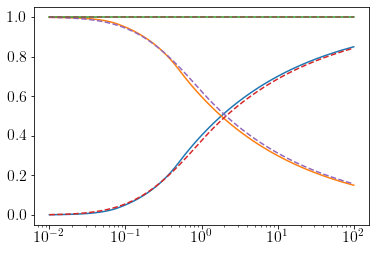

In [59]:
plt.plot(mass_bound, missing_mass['Kroupa'][:,1:], linestyle='-')
plt.plot(mass_bound, np.sum(missing_mass['Kroupa'][:,1:], axis=1), linestyle='-')

plt.plot(mass_bound, missing_mass['Chabrier'][:,1:], linestyle='--')
plt.plot(mass_bound, np.sum(missing_mass['Chabrier'][:,1:], axis=1), linestyle='--')

plt.xscale('log')

# Usable mass fraction

In [61]:
for cmpt in iso_properties:
    m_min = iso_properties[cmpt]['isointerp_inv'](12)
    m_max = np.max(iso_properties[cmpt]['isochrone']['mini'])
    I, Ilow, Ihigh = initial_mass_fraction(m_min, m_max, model='Kroupa')
    print(f"{cmpt.ljust(5)}: {m_min:.3f}-{Ilow:.3f}, {m_max:.3f}-{Ihigh:.3f}, multiplier:{1/(1-(Ilow+Ihigh)):.3f}")
print("This doesn't account for mass loss or include WDs")

thin : 0.177-0.101, 1.083-0.584, multiplier:3.170
thick: 0.147-0.082, 1.049-0.589, multiplier:3.046
halo : 0.115-0.061, 0.801-0.639, multiplier:3.336
This doesn't account for mass loss or include WDs


In [196]:
12.43*3.17 + 4.99*3.046 + 0.42*3.336

56.00375999999999

In [62]:
for cmpt in iso_properties:
    try: pre_death = iso_properties[cmpt]['isochrone']['label']<9
    except KeyError:
        pre_death = np.ones(len(iso_properties[cmpt]['isochrone']['gmag']), dtype=bool)
        pre_death[-1]=False
    iso_properties[cmpt]['isointerp_inv'] = scipy.interpolate.interp1d(iso_properties[cmpt]['isochrone']['gmag'][pre_death],
                                                                   iso_properties[cmpt]['isochrone']['mini'][pre_death], 
                                                                      bounds_error=False, fill_value=np.nan)
    iso_properties[cmpt]['isointerp_minv'] = scipy.interpolate.interp1d(iso_properties[cmpt]['isochrone']['gmag'][pre_death],
                                                                   iso_properties[cmpt]['isochrone']['mass'][pre_death], 
                                                                      bounds_error=False, fill_value=np.nan)

In [65]:
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    mass_sample = iso_properties[cmpt]['massinterp'](mini_sample)
    massloss_mean = np.nanmean((mass_sample/mini_sample)[g_sample<12])
    
    m_min = iso_properties[cmpt]['isointerp_inv'](12)
    m_argmax = np.argmax(iso_properties[cmpt]['isochrone']['mini'])
    m_max = iso_properties[cmpt]['isochrone']['mini'][m_argmax]
    massloss_min = iso_properties[cmpt]['isointerp_minv'](12)/iso_properties[cmpt]['isointerp_inv'](12)
    massloss_max = iso_properties[cmpt]['isochrone']['mass'][m_argmax]/m_max
    I, Ilow, Ihigh = initial_mass_fraction(m_min, m_max, model='Chabrier')
    print(f"{cmpt.ljust(5)}: {m_min:.3f}-{Ilow:.3f}-{massloss_min:.3f}, {m_max:.3f}-{Ihigh:.3f}-{massloss_max:.3f}, multiplier:{((1-(Ilow+Ihigh))*massloss_mean + Ilow*massloss_min + Ihigh*massloss_max)/(1-(Ilow+Ihigh))*massloss_mean:.3f}")
print("This doesn't include WDs.")

thin : 0.177-0.104-1.000, 1.083-0.610-0.496, multiplier:2.415
thick: 0.147-0.086-0.999, 1.049-0.616-0.511, multiplier:2.337
halo : 0.115-0.066-1.000, 0.801-0.666-0.690, multiplier:2.956
This doesn't include WDs.


In [67]:
massloss_mean = np.nanmean((mass_sample/mini_sample)[g_sample<12])
print(massloss_mean)
for cmpt in iso_properties:
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    mass_sample = iso_properties[cmpt]['massinterp'](mini_sample)
    massloss_mean = np.nanmean((mass_sample/mini_sample)[g_sample<12])
    
    m_min = iso_properties[cmpt]['isointerp_inv'](12)
    m_argmax = np.argmax(iso_properties[cmpt]['isochrone']['mini'])
    m_max = iso_properties[cmpt]['isochrone']['mini'][m_argmax]
    massloss_min = iso_properties[cmpt]['isointerp_minv'](12)/iso_properties[cmpt]['isointerp_inv'](12)
    massloss_max = iso_properties[cmpt]['isochrone']['mass'][m_argmax]/m_max
    I, Ilow, Ihigh = initial_mass_fraction(m_min, m_max, model='Chabrier')
    print(f"{cmpt.ljust(5)}: {m_min:.3f}-{Ilow:.3f}-{massloss_min:.3f}, {m_max:.3f}-{Ihigh:.3f}-{massloss_max:.3f}, multiplier:{1/(1-Ilow):.3f}")
print("This doesn't include WDs.")

0.998654171681674
thin : 0.177-0.104-1.000, 1.083-0.610-0.496, multiplier:1.116
thick: 0.147-0.086-0.999, 1.049-0.616-0.511, multiplier:1.094
halo : 0.115-0.066-1.000, 0.801-0.666-0.690, multiplier:1.070
This doesn't include WDs.


In [194]:
Flynn_stars = 0.4 + 0.9 + 0.6 + 1.1 + 1.7 + 5.7 + 10.9

In [195]:
Flynn_stars

21.3

In [70]:
1.116*0.4127

0.46057320000000007

In [38]:
mean_mass_g12

0.30833001524636633

In [68]:
for cmpt in iso_properties:
    
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    mean_mass_g12 = np.nanmean((mass_sample)[g_sample<12])
    
    m_min = iso_properties[cmpt]['isointerp_inv'](12)
    m_argmax = np.argmax(iso_properties[cmpt]['isochrone']['mini'])
    m_max = iso_properties[cmpt]['isochrone']['mini'][m_argmax]
    
    # Integral of IMF
    Iint, Ilow, Ihigh = imf_fraction(m_min, m_max, model='Kroupa')
    
    # Mean initial mass
    Mint, Mlow, Mhigh = initial_mass_fraction(m_min, m_max, model='Kroupa')
    X = (1-Ihigh)/(1-Ilow-Ihigh)
    Mmean = (Mint*Mlow+mean_mass_g12*Iint*(1-Ilow-Ihigh))/(Iint*(1-Ihigh))
    print(f"{cmpt.ljust(5)}: {m_min:.3f}-{Ilow:.3f}, {m_max:.3f}-{Ihigh:.3f}")
    print(f"{cmpt.ljust(5)}: X:{X:.3f}, <M>:{Mmean:.3f}, multiplier:{X*Mmean:.3f}")
    #print(f"{cmpt.ljust(5)}: <M>:{(Mint*(1-Mhigh))/(Iint*(1-Ihigh)):.3f}")
print("This doesn't include WDs.")

thin : 0.177-0.650, 1.083-0.049
thin : X:3.165, <M>:0.161, multiplier:0.508
thick: 0.147-0.604, 1.049-0.052
thick: X:2.758, <M>:0.159, multiplier:0.439
halo : 0.115-0.540, 0.801-0.073
halo : X:2.398, <M>:0.155, multiplier:0.372
This doesn't include WDs.


In [69]:
for cmpt in iso_properties:
    
    g_sample = iso_properties[cmpt]['isointerp'](mini_sample)
    mean_mass_g12 = np.nanmean((mass_sample)[g_sample<12])
    
    m_min = iso_properties[cmpt]['isointerp_inv'](12)
    m_argmax = np.argmax(iso_properties[cmpt]['isochrone']['mini'])
    m_max = iso_properties[cmpt]['isochrone']['mini'][m_argmax]
    m_max=2
    
    # Integral of IMF
    Iint, Ilow, Ihigh = imf_fraction(m_min, m_max, model='Kroupa')
    
    # Mean initial mass
    Mint, Mlow, Mhigh = initial_mass_fraction(m_min, m_max, model='Kroupa')
    X = (1-Ihigh)/(1-Ilow-Ihigh)
    Mmean = (Mint*Mlow+mean_mass_g12*Iint*(1-Ilow-Ihigh))/(Iint*(1-Ihigh))
    print(f"{cmpt.ljust(5)}: {m_min:.3f}-{Ilow:.3f}, {m_max:.3f}-{Ihigh:.3f}")
    print(f"{cmpt.ljust(5)}: X:{X:.3f}, <M>:{Mmean:.3f}, multiplier:{X*Mmean:.3f}")
    #print(f"{cmpt.ljust(5)}: <M>:{(Mint*(1-Mhigh))/(Iint*(1-Ihigh)):.3f}")
print("This doesn't include WDs.")

thin : 0.177-0.650, 2.000-0.022
thin : X:2.985, <M>:0.166, multiplier:0.497
thick: 0.147-0.604, 2.000-0.022
thick: X:2.620, <M>:0.165, multiplier:0.432
halo : 0.115-0.540, 2.000-0.022
halo : X:2.235, <M>:0.163, multiplier:0.364
This doesn't include WDs.


In [64]:
Mint/Iint, \
Mint*(1-Mlow-Mhigh)/(Iint*(1-Ilow-Ihigh)), \
Mint*(1-Mhigh)/(Iint*(1-Ihigh))

(0.39813784130028584, 0.41820730287780056, 0.1743999781706032)

In [56]:
(1-Mlow)/(1-Ilow)

2.0417073005641417

In [55]:
Ilow, Mlow

(0.5402786480140261, 0.061383559425019586)

In [65]:
mean_mass_g12

0.3741590746270716

In [61]:
mean_mass_g12*Iint*(1-Ilow-Ihigh), Mint*(1-Mlow-Mhigh)

(0.06675159802016069, 0.06684737467749813)

In [51]:
Mlow, Ilow

(0.061383559425019586, 0.5402786480140261)

In [67]:
np.nanmean((mass_sample)[g_sample<12])/np.nanmean((mini_sample)[g_sample<12])

0.8960541519249484

# White Dwarfs

In [145]:
import sqlutilpy
sys.path.append('/home/andy/Documents/software/')
import getdata

In [147]:
query = """select floor((phot_bp_mean_mag-phot_rp_mean_mag)*10)/10 as colbin,
                  floor((phot_g_mean_mag-10+2.5*LOG(parallax))*10)/10 as absbin,
                    count(*) from andy_everall.gaia3_rand100m
                where parallax/parallax_error>4
                group by colbin, absbin"""
%time cmbins = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 56 s


In [191]:
rng = [[0,14],[-2,5]]
grid = np.zeros((int((rng[0][1]-rng[0][0])*10+0.1),
                 int((rng[1][1]-rng[1][0])*10+0.1)), dtype=int)

absid = ((cmbins['absbin']-rng[0][0])*10+0.1).astype(int)
colid = ((cmbins['colbin']-rng[1][0])*10+0.1).astype(int)
good_id = (absid>=0)&(absid<grid.shape[0])&(colid>=0)&(colid<grid.shape[1])

grid[absid[good_id],colid[good_id]] = cmbins['count'][good_id]

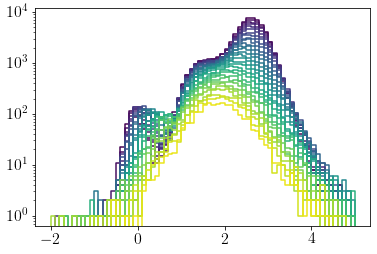

In [187]:
Mmin = 10;
cmap = cm.viridis
for ii in range(int((Mmin-rng[0][0])/0.1), grid.shape[0]):
    y = np.insert(np.repeat(grid[ii],2), (0,grid.shape[1]*2), (0,0))
    x = np.repeat(np.linspace(rng[1][0], rng[1][1], grid.shape[1]+1), 2)
    plt.plot(x,y, c=cmap((ii*0.1-Mmin)/(rng[0][1]-Mmin)))
    plt.yscale('log')

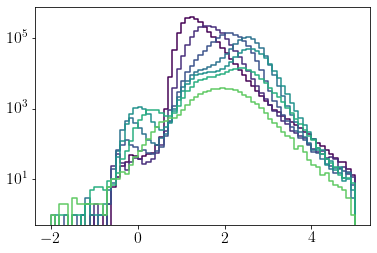

In [204]:
Mmin = 6;
Mags = [6, 7, 8, 9, 10, 11, 12, 13]
cmap = cm.viridis
for ii, M in enumerate(Mags[:-1]):
    jj = int((M-rng[0][0])/0.1)
    jj_next = int((Mags[ii+1]-rng[0][0])/0.1)
    grid
    
    y = np.insert(np.repeat(np.sum(grid[jj:jj_next], axis=0),2), (0,grid.shape[1]*2), (0,0))
    x = np.repeat(np.linspace(rng[1][0], rng[1][1], grid.shape[1]+1), 2)
    plt.plot(x,y, c=cmap((jj*0.1-Mmin)/(rng[0][1]-Mmin)))
    plt.yscale('log')

(14.0, 0.0)

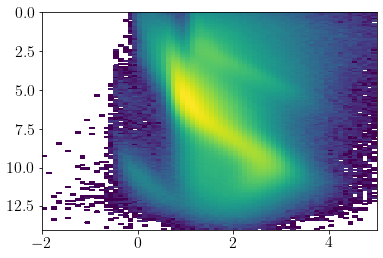

In [203]:
x = np.linspace(rng[1][0], rng[1][1], grid.shape[1]+1)
y = np.linspace(rng[0][0], rng[0][1], grid.shape[0]+1)
plt.pcolor(x,y,grid, norm=LogNorm())
plt.ylim(rng[0][1], rng[0][0])

In [151]:
np.unique(cmbins['absbin'])

array([-6.6, -6.2, -6.1, -5.8, -5.4, -5.3, -5.1, -5. , -4.9, -4.8, -4.7,
       -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4. , -3.9, -3.8, -3.7, -3.6,
       -3.5, -3.4, -3.3, -3.2, -3.1, -3. , -2.9, -2.8, -2.7, -2.6, -2.5,
       -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4,
       -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3,
       -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,
        0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,
        2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,
        3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,
        4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,
        5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,
        6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,
        7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,
        8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9

# Old notes

In [185]:
def M_model(M):

    alpha1=-0.5; alpha2=-0.5
    Mms2=7.99; Mms=8; Mms1=8.01; 
    Mto=-10
    alpha3=-1.
    fD=0.99
    

    ep1=1.3; ep2=2.3;
    a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);

    alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
    Ag = 1/a1 * np.exp((alpha1-alphag)*(Mms-Mms1))

    # Latent variables
    n1 = -(4 + alpha1*5/np.log(10))
    ng = -(4 + alphag*5/np.log(10))
    n2 = -(4 + alpha2*5/np.log(10))
    n3 = -(4 + alpha3*5/np.log(10))

    pop1 = M>Mms1
    popg = M>Mms2
    pop2 = M>Mto

    
    b=np.array([a2/alpha1, -a2/alpha1,
                a2/alphag, -a2/alphag,
                a1/alpha2, -a1/alpha2])
    exponent = np.array([alpha1*(Mms-Mms1), alpha1*(Mms-Mx),
                                                alpha1*(Mms-Mms1)+alphag*(Mms1-Mms2), alpha1*(Mms-Mms1),
                                                alpha2*(Mms-Mto), alpha2*(Mms-Mms2)])
    
    log_Ams = np.log( fD*a1*a2 ) - \
              scipy.special.logsumexp(exponent,
                                    b=b)
    log_AG = np.log(-alpha3) + np.log(1-fD)

    log_m = np.where(pop1,  - np.log(a1) + alpha1*(Mms-M),
            np.where(popg,  + np.log(Ag) + alphag*(Mms-M),
            np.where(pop2,  - np.log(a2) + alpha2*(Mms-M),
                           log_AG  + alpha3*(Mto-M))))

    return np.sum(np.log(m))

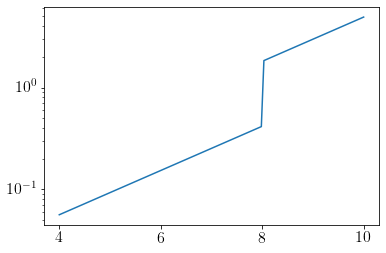

In [186]:
plt.plot(MG, M_model(MG))
plt.yscale('log')

In [95]:
alpha1=-0.5; alpha2=-0.5
ep1=1.3; ep2=2.3;
mb = 0.5
a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);
Mms=8

In [104]:
mag_sample = np.zeros(len(mini_sample))
mag_sample[mini_sample<mb] = (-2.5*a1/np.log(10))*(np.log(mini_sample[mini_sample<mb]) - np.log(mb)) + Mms
mag_sample[mini_sample>mb] = (-2.5*a2/np.log(10))*(np.log(mini_sample[mini_sample>mb]) - np.log(mb)) + Mms

In [107]:
def model(MG, Mto=4, Mx=12):
    
    norm = mb**(-ep2)/a2 * (np.exp(a2*Mms) - np.exp(a2*Mto)) + mb**(-ep1)/a1 * (np.exp(a1*Mx - np.exp(a1*Mms)))
    
    result = np.zeros(MG.size)
    result[MG<Mms] = mb**(-ep1)*np.exp(-alpha1*MG[MG<Mms])
    result[MG>Mms] = mb**(-ep2)*np.exp(-alpha2*MG[MG>Mms])
    
    return result/norm

In [136]:
def model(MG, Mto=4, Mx=12):
    
    norm=1.
    
    result = np.zeros(MG.size)
    result[MG<Mms] = - np.log(a1) + alpha1*(Mms-MG[MG<Mms])
    result[MG>Mms] = - np.log(a2) + alpha2*(Mms-MG[MG>Mms])
    
    return np.exp(result)/norm

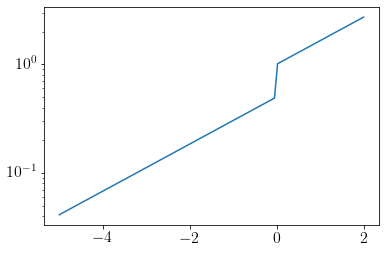

In [121]:
Mms

8

In [120]:
MG.size

120

In [130]:
a1

0.5526204223185711

In [137]:
model(MG)

array([0.24489736, 0.25114972, 0.25756171, 0.26413741, 0.27088098,
       0.27779672, 0.28488902, 0.29216239, 0.29962146, 0.30727095,
       0.31511575, 0.32316083, 0.3314113 , 0.33987241, 0.34854954,
       0.3574482 , 0.36657405, 0.37593288, 0.38553065, 0.39537346,
       0.40546756, 0.41581937, 0.42643546, 0.43732259, 0.44848768,
       0.45993781, 0.47168028, 0.48372253, 0.49607223, 0.50873723,
       0.52172556, 0.5350455 , 0.54870551, 0.56271426, 0.57708066,
       0.59181384, 0.60692317, 0.62241825, 0.63830893, 0.65460531,
       0.67131774, 0.68845684, 0.70603352, 0.72405894, 0.74254456,
       0.76150213, 0.7809437 , 0.80088161, 0.82132856, 0.84229753,
       0.86380184, 0.88585517, 0.90847154, 0.93166531, 0.95545124,
       0.97984443, 1.00486039, 1.03051502, 1.05682463, 1.08380594,
       1.1114761 , 1.13985269, 1.16895375, 1.19879778, 1.22940374,
       1.26079109, 1.29297977, 1.32599025, 1.35984351, 1.39456105,
       1.43016496, 1.46667785, 1.50412293, 1.54252401, 1.58190

In [148]:
M_model(MG)

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

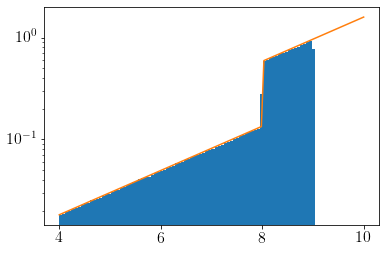

In [193]:
plt.hist(mag_sample, bins=100, range=(4,10), density=True);

MG=np.linspace(4,10,120)
plt.plot(MG, M_model(MG)/3.1)
plt.yscale('log')

In [ ]:

    # Input Parameters
    ncomponents=fid_pars['ncomponents']
    transformed_params = combined_params(params, fid_pars, ncomponents=ncomponents)

    dist_cmpts = np.zeros((len(M), ncomponents))
    weights = np.zeros(ncomponents)
    for j in range(ncomponents):
        alpha1=transformed_params[j]['alpha1']; alpha2=transformed_params[j]['alpha2']; alpha3=transformed_params[j]['alpha3']
        Mms=transformed_params[j]['Mms']; Mms1=transformed_params[j]['Mms1']; Mms2=transformed_params[j]['Mms2']; Mto=transformed_params[j]['Mto'];
        fD=transformed_params[j]['fD']; Mx=fid_pars['Mmax']



        alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
        Ag = 1/a1 * np.exp((alpha1-alphag)*(Mms-Mms1))

        # Latent variables
        n1 = -(4 + alpha1*5/np.log(10))
        ng = -(4 + alphag*5/np.log(10))
        n2 = -(4 + alpha2*5/np.log(10))
        n3 = -(4 + alpha3*5/np.log(10))

        pop1 = M>Mms1
        popg = M>Mms2
        pop2 = M>Mto

        log_Ams = np.log( fD*a1*a2 ) - \
                  scipy.special.logsumexp(np.array([alpha1*(Mms-Mms1), alpha1*(Mms-Mx),
                                                    alpha1*(Mms-Mms1)+alphag*(Mms1-Mms2), alpha1*(Mms-Mms1),
                                                    alpha2*(Mms-Mto), alpha2*(Mms-Mms2)]),
                                        b=np.array([a2/alpha1, -a2/alpha1,
                                                    a2/alphag, -a2/alphag,
                                                    a1/alpha2, -a1/alpha2]))
        log_AG = np.log(-alpha3) + np.log(1-fD)

        log_m = np.where(pop1, log_Ams - np.log(a1) + alpha1*(Mms-M),
                np.where(popg, log_Ams + np.log(Ag) + alphag*(Mms-M),
                np.where(pop2, log_Ams - np.log(a2) + alpha2*(Mms-M),
                               log_AG  + alpha3*(Mto-M))))

        m_dist = np.exp(log_m)
        m_dist[M>fid_pars['Mmax']]=0.
        dist_cmpts[:,j] = m_dist

        weights[j] = transformed_params[j]['w']

    if model=='combined': return  np.sum(weights*dist_cmpts, axis=1)
    elif model=='all':    return        (weights*dist_cmpts)

### Tip of the RGB

In [284]:
for cmpt in iso_properties:
    print(cmpt, np.min(iso_properties[cmpt]['isochrone']['gmag']))

thin -3.996
thick -3.532
halo -3.718


# Young disk

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py, emcee
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

# Isochrones

In [7]:
sys.path.append('/home/andy/Documents/software/')
import sqlutilpy, getdata

In [43]:
iso_properties = {'thin':{'age':5.7e9,   'feh':-0.3},
                 'thick':{'age':7.8e9, 'feh':-0.7},
                 'halo':{'age':13e9, 'feh':-1.5}}

In [44]:
for observable in ['age', 'feh']:
    query = f"""select distinct {observable} from isochrones.gaia_1804"""
    %time uniage=sqlutilpy.get(query, asDict=True, **getdata.sql_args)

    for cmpt in iso_properties:
        iso_properties[cmpt]['iso'+observable] = uniage[observable][np.argmin(np.abs(uniage[observable] - iso_properties[cmpt][observable]))]

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.24 s
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 4.74 s


In [45]:
for cmpt in iso_properties:
    query = f"""select gmag, g_bpmag, g_rpmag, mini, mass, age, feh, label from isochrones.gaia_1804
                    where age={iso_properties[cmpt]['isoage']}  and   feh={iso_properties[cmpt]['feh']}"""
    %time iso_properties[cmpt]['isochrone']=sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 911 ms
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 454 ms
CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 453 ms


In [46]:
kwargs = {'thin':{'c':'tab:orange','alpha':1, 'linestyle':'-', 'label':'thin disk', 'linewidth':2}, 
           'thick':{'c':'tab:green','alpha':1, 'linestyle':'-', 'label':'thick disk', 'linewidth':2}, 
           'halo':{'c':'tab:purple','alpha':1, 'linestyle':'-', 'label':'halo', 'linewidth':2}}

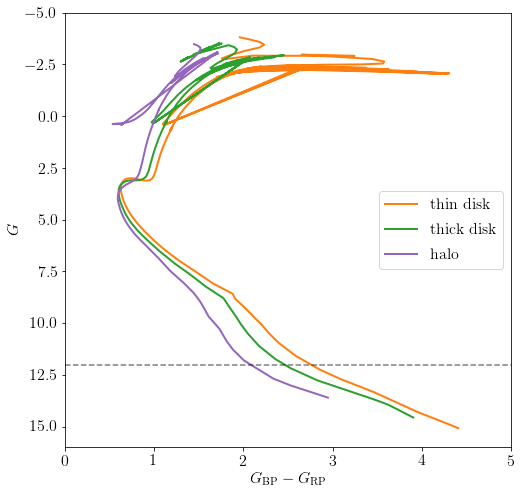

In [47]:
fig, axes = plt.subplots(1,1,figsize=(8,8), sharey=True)

for cmpt in iso_properties:
    pre_death = iso_properties[cmpt]['isochrone']['label']<9
    plt.plot((iso_properties[cmpt]['isochrone']['g_bpmag']-iso_properties[cmpt]['isochrone']['g_rpmag'])[pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.ylim(16, -5); plt.xlim(0,5); plt.xlabel(r'$G_\mathrm{BP}-G_\mathrm{RP}$'); plt.ylabel(r'$G$');
plt.legend(loc='center right')

xlims = axes.get_xlim()
plt.plot([xlims[0], xlims[1]], [12,12], '--k', alpha=0.5)

In [15]:
iso_properties['thin']['isochrone'].keys()

odict_keys(['gmag', 'g_bpmag', 'g_rpmag', 'mini', 'mass', 'age', 'feh', 'label'])

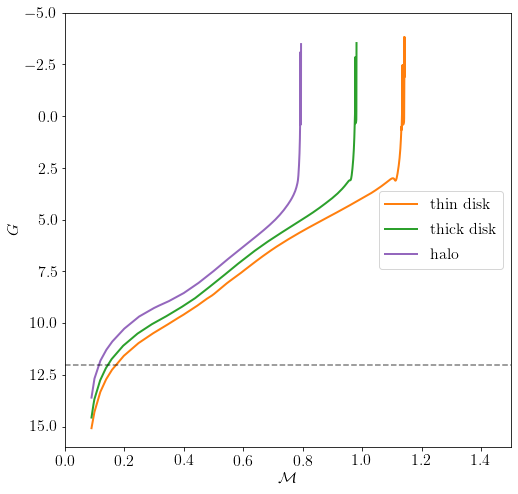

In [48]:
fig, axes = plt.subplots(1,1,figsize=(8,8), sharey=True)

for cmpt in iso_properties:
    pre_death = iso_properties[cmpt]['isochrone']['label']<9
    plt.plot(iso_properties[cmpt]['isochrone']['mini'][pre_death], 
             iso_properties[cmpt]['isochrone']['gmag'][pre_death],
             **kwargs[cmpt])
plt.ylim(16, -5); plt.xlim(0,1.5); plt.xlabel(r'$\mathcal{M}$'); plt.ylabel(r'$G$');
plt.legend(loc='center right')

xlims = axes.get_xlim()
plt.plot([xlims[0], xlims[1]], [12,12], '--k', alpha=0.5)

In [49]:
grad.shape

(328,)

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


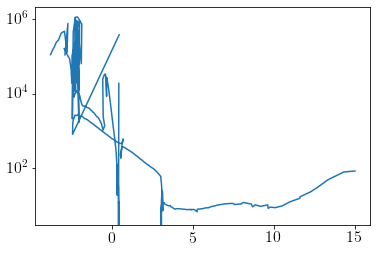

In [50]:
cmpt = 'thin'
pre_death = iso_properties[cmpt]['isochrone']['label']<9
_mini_test = iso_properties[cmpt]['isochrone']['mini'][pre_death]
_gmag_test = iso_properties[cmpt]['isochrone']['gmag'][pre_death]

grad = (_gmag_test[1:]-_gmag_test[:-1])/(_mini_test[1:]-_mini_test[:-1])

plt.plot(_gmag_test[1:], np.abs(grad))
plt.yscale('log')

In [68]:
interp = scipy.interpolate.interp1d(_gmag_test, _mini_test)
grad = 0.1/(interp(np.arange(-2.,10.1,0.1))-interp(np.arange(-2.1,10.,0.1)))
Mini = interp(np.arange(-2.05,10.,0.1))

In [66]:
np.arange(-2.05,10.1,0.1).shape

(122,)

In [69]:
print(np.vstack(((np.arange(-2.05,10.,0.1), Mini, grad))).T)

[[-2.05000000e+00  1.13665392e+00 -7.94097001e+01]
 [-1.95000000e+00  1.13883873e+00 -1.91323345e+01]
 [-1.85000000e+00  1.13996573e+00  2.82865889e+01]
 [-1.75000000e+00  1.13569344e+00 -8.79915162e+02]
 [-1.65000000e+00  1.14098989e+00 -4.55202743e+01]
 [-1.55000000e+00  1.13875214e+00  2.07208943e+01]
 [-1.45000000e+00  1.13632086e+00 -4.42403280e+01]
 [-1.35000000e+00  1.14116740e+00 -5.27225953e+01]
 [-1.25000000e+00  1.13914272e+00 -5.03789367e+01]
 [-1.15000000e+00  1.14111006e+00 -3.08034786e+02]
 [-1.05000000e+00  1.13442701e+00  2.41380401e+01]
 [-9.50000000e-01  1.13435328e+00 -8.04927523e+01]
 [-8.50000000e-01  1.14064292e+00 -8.44120251e+01]
 [-7.50000000e-01  1.14014217e+00 -8.87100398e+01]
 [-6.50000000e-01  1.13944453e+00  6.17571741e+03]
 [-5.50000000e-01  1.13918618e+00  2.88720866e+01]
 [-4.50000000e-01  1.13786336e+00  4.69240836e+01]
 [-3.50000000e-01  1.14065960e+00 -1.44063597e+02]
 [-2.50000000e-01  1.13456161e+00 -5.68919968e+01]
 [-1.50000000e-01  1.13350737e+

In [52]:
order = np.argsort(_gmag_test[1:]+_gmag_test[:-1])
print(np.vstack(((_gmag_test[1:]+_gmag_test[:-1])/2, _mini_test[1:], grad)).T[order])

[[-3.75350000e+00  1.14139867e+00 -1.10097515e+05]
 [-3.64150000e+00  1.14139771e+00 -1.42600359e+05]
 [-3.51950000e+00  1.14139688e+00 -1.74776286e+05]
 [-3.38650000e+00  1.14139616e+00 -2.36537494e+05]
 [-3.23450000e+00  1.14139557e+00 -2.73489933e+05]
 [-3.05350000e+00  1.14139497e+00 -4.17365772e+05]
 [-2.93750000e+00  1.14139342e+00             inf]
 [-2.91350000e+00  1.14139354e+00 -1.09060403e+05]
 [-2.87000000e+00  1.14139450e+00 -4.69667319e+05]
 [-2.86300000e+00  1.14139342e+00 -1.60146420e+05]
 [-2.83000000e+00  1.14139378e+00  7.55033556e+05]
 [-2.76300000e+00  1.14139414e+00 -1.28635347e+05]
 [-2.69500000e+00  1.14139211e+00 -1.05695831e+05]
 [-2.58650000e+00  1.14139092e+00 -8.48168515e+04]
 [-2.51950000e+00  1.14138985e+00 -4.50875537e+04]
 [-2.49000000e+00  1.14138889e+00 -1.91754554e+04]
 [-2.46150000e+00  1.14134729e+00 -2.09716882e+03]
 [-2.45750000e+00  1.14134586e+00 -5.24273881e+03]
 [-2.45200000e+00  1.14138806e+00 -1.00654253e+05]
 [-2.44500000e+00  1.13511789e+